In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from __future__ import division
from datetime import datetime

alpha = 0.05

# from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import scipy.stats as stats

pd.set_option('display.max_columns', 100)

In [3]:
sns.set(font_scale=1.6)
sns.set(style='ticks')
font = {'size' : 25}
plt.rc('font', **font)

In [4]:
df = pd.read_csv('./data/esm_filtered_3.csv')
df2 = pd.read_csv('./data/lab_alerts_info.csv')

Drop First three artifact columns

In [5]:
cols = df.columns.tolist()
df.drop(labels=cols[:3], axis=1, inplace=True)

In [6]:
df.head(3)

row_id   user_id                                         record_id  \
0  464179  c2822848  4691a568625.a78f14cf-a990-44fc-9d26-8dd399dfd13d   
1  464187  37f0423c  4691ba46297.fea93b6e-c053-4cdb-9917-a86e16e3d820   
2  464189  cf7c120d  4691bf837e8.6cb3c170-bd4a-4e40-8504-d49a900010ca   

     recordReceived_ISO8601  recordReceived_secondsSinceMidnight1Jan1970UTC  \
0  2016-05-14T19:13:16.195Z                                      1463253196   
1  2016-05-14T19:49:44.834Z                                      1463255384   
2  2016-05-14T19:58:53.366Z                                      1463255933   

   previousResponsesOfTypeForUser          startTime_ISO8601  \
0                              16  2016-05-14T15:12:05-04:00   
1                              11  2016-05-14T15:48:07-04:00   
2                              14  2016-05-14T15:56:57-04:00   

   startTime_secondsSinceMidnight1Jan1970UTC  \
0                                 1463253125   
1                                 1463255287   
2                                 1463255817   

                               inResponseToAlert_id  \
0  4691a4bd5de.2b8d43d7-ebed-4a0d-aed1-6ae4c33514a7   
1  4691b95c728.8c2688df-4e4d-4c1c-9c0c-a4369f8873d8   
2  4691be69915.4b9af48c-4f6f-4df3-8c28-852319382a8c   

   estimatedSecondsSinceAlert  wantingAnything         whatWanting  \
0                        63.0              0.0                 NaN   
1                       166.0              2.0       A tea steeper   
2                       307.0              2.0  To be less anxious   

   wantingIntensity  wantedToFeel_pleasant  wantedToFeel_control  \
0               NaN                      0                     0   
1               1.0                      0                     1   
2               1.0                      0                     1   

   wantedToFeel_goodAboutMe  wantedToFeel_connected  wantedToFeel_comfort  \
0                         0                       0                     0   
1                         0                       0                     0   
2                         0                       0                     1   

   wantedToFeel_calm  wantedToFeel_excited  wantedToFeel_competent  \
0                  0                     0                       0   
1                  0                     0                       0   
2                  0                     0                       1   

   wantedToFeel_acknowledged  wantedToFeel_alert  wantedToFeel_other  \
0                          0                   0                   0   
1                          0                   0                   0   
2                          0                   0                   0   

  wantedToFeel_specifiedOther  wantedToFeel_nothingInParticular    doing  \
0                         NaN                                 0    other   
1                         NaN                                 0    other   
2                         NaN                                 0  leisure   

            doing_specifiedOther  withOthers  feelingBadToGood  energy  \
0  Relaxing with friends outside         2.0             0.882   0.498   
1                     Making tea         0.0             0.833   0.815   
2                            NaN         2.0             0.755   1.000   

   physically_hungry  physically_tired  physically_uncomfortable  \
0                  0                 0                         0   
1                  0                 0                         0   
2                  0                 0                         0   

   physically_energized  physically_good  physically_other  \
0                     0                1                 0   
1                     0                1                 0   
2                     1                0                 0   

  physically_specifiedOther  physically_noFeeling  feeling_angry  \
0                       NaN                     0              0   
1                       NaN  

In [7]:
df.shape

(6116, 75)

In [8]:
df['user_id'].unique().shape

(95,)

In [9]:
print df.shape[0] / df['user_id'].unique().shape[0]

64.3789473684


Split up columns by question

In [10]:
continuous_cols = ['wantingIntensity','feelingBadToGood', 'energy', 'thinkingOverAndOver', 'comparingToOthers', \
                   'stressed', 'lonely','selfWorth','appreciating']

feeling_type_cols = cols[cols.index('feeling_angry'):cols.index('feelingIntensity_sad')+1:2] \
                        + ['feeling_other'] \
                        + ['feeling_noEmotion']
        
wanted_to_feel_cols = cols[cols.index('wantedToFeel_pleasant'):cols.index('wantedToFeel_nothingInParticular')+1]

feeling_cols = cols[cols.index('feeling_angry'):cols.index('feeling_other')+1] + ['feeling_noEmotion']

physical_cols = cols[cols.index('physically_hungry'):cols.index('physically_noFeeling')+1]

In [ ]:
# I guess there are rows that have no option selected for 'wanted to feel'
df['wantedToFeel_noOptionSelected'] = df[wanted_to_feel_cols].any(axis=1).apply(lambda x: 1 if x is True else 0)

### 1. Frequency Distribution of all Continuous Variables

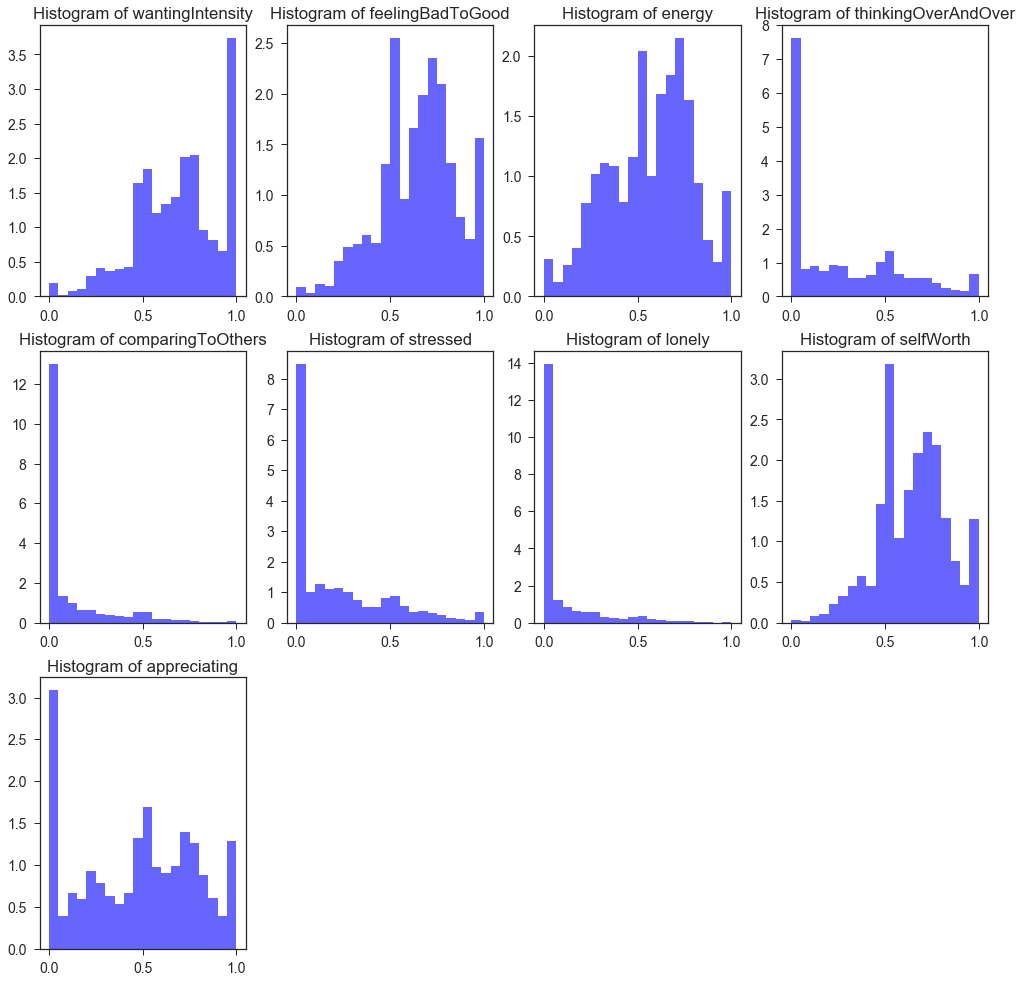

In [67]:
bins = 20
plt.figure(figsize=(17,17))

sns.set(font_scale=1.4, style='ticks')
for i in range(9):
    plt.subplot(3, 4, i+1)
    sns.distplot(a=df[continuous_cols[i]].dropna(axis=0).values, bins=bins, norm_hist=True, kde=False, color='blue', hist_kws={'alpha':0.6}, kde_kws={'color':'red', 'linewidth':1.5, 'alpha':0.6})
    plt.title('Histogram of {}'.format(continuous_cols[i]))
    
plt.savefig('./images-esm/Histogram of Continuous Variables')

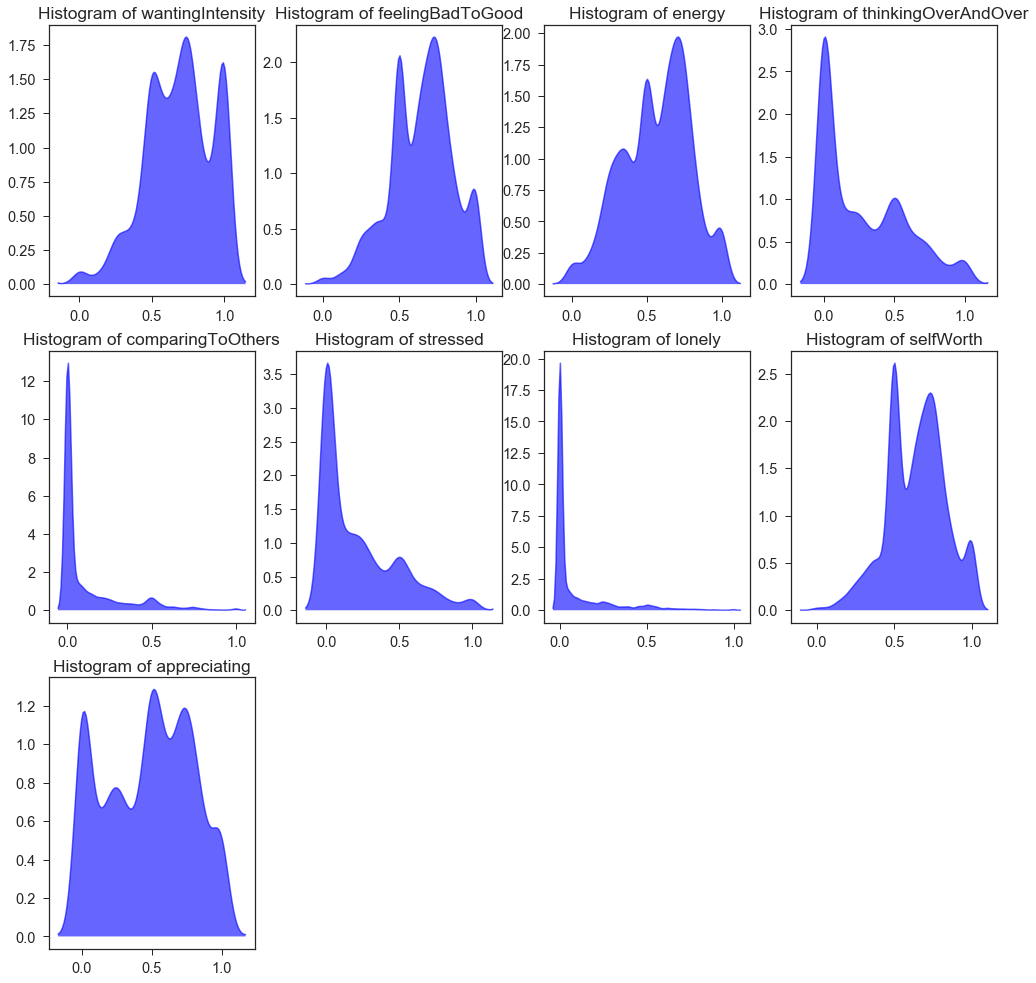

In [68]:
bins = 20
plt.figure(figsize=(17,17))

sns.set(font_scale=1.45, style='ticks')

for i in range(9):
    plt.subplot(3, 4, i+1)
    sns.distplot(a=df[continuous_cols[i]].dropna(axis=0).values, hist=False, bins=bins, norm_hist=False, kde=True, color='b', \
             hist_kws={'alpha':0.6}, \
             kde_kws={'color':'blue', 'linewidth':1.5, 'alpha':0.6, 'shade':True})
    plt.title('Histogram of {}'.format(continuous_cols[i]))
    
plt.savefig('./images-esm/KDE (Histograms) of Continuous Variables')
    
    

Calculate standard deviations of sample distributions

In [69]:
# for i in range(len(continuous_cols)):
    

# Time Series
----

**Pre-process**

In [71]:
df['startTime_ISO8601'] = pd.to_datetime(df['startTime_ISO8601'].apply(lambda x: x[:-6]), format='%Y-%m-%dT%H:%M:%S')

df['hour'] = df['startTime_ISO8601'].dt.hour

df['dayofweek'] = df['startTime_ISO8601'].dt.dayofweek

labels = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']

## Hourly Averages for All Continuous Variables
---


**Scaled Using Max/Min**

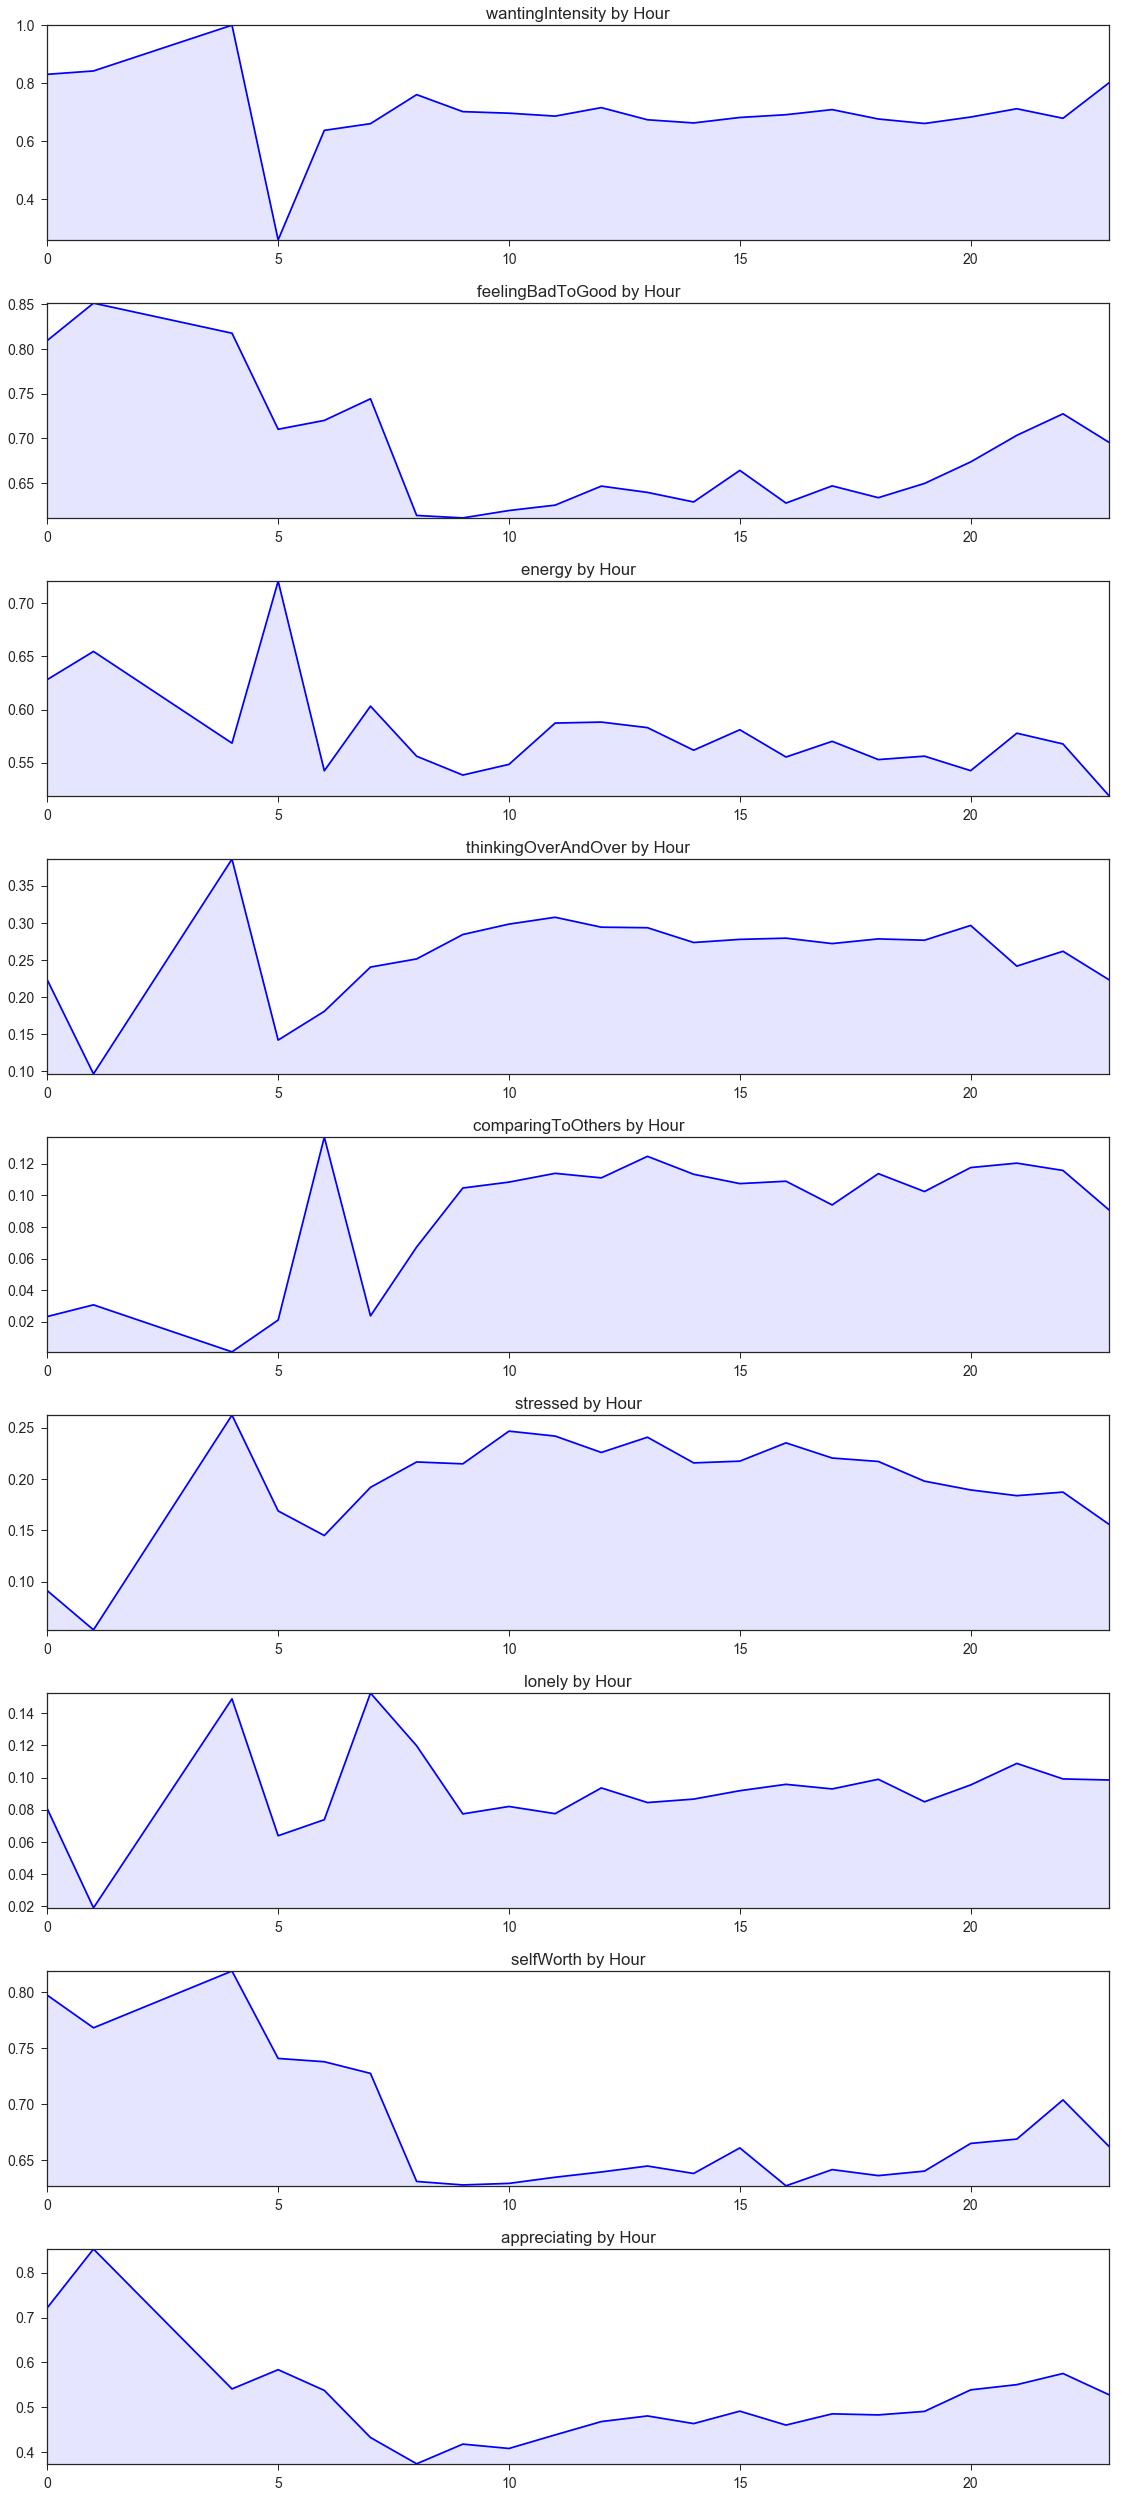

In [19]:
sns.set(font_scale=1.4, style='ticks')

plt.figure(figsize=(16,35))

for i in range(len(continuous_cols)):
    
    ax = plt.subplot(len(continuous_cols), 1, i+1)
    
    grouped = df.iloc[df[continuous_cols[i]].dropna(axis=0).index].groupby(by='hour')[continuous_cols[i]].mean()
    plt.plot(grouped.index.values, grouped.values, color='blue')
    
    plt.fill_between(x=grouped.index.values, y1=grouped.values, y2=np.min(grouped.values), facecolor='blue', alpha=0.1)
    
    plt.xlim((0,23))
    
    ylim_hi = grouped.max() #* 1.2
    ylim_lo = grouped.min() #* 0.8
#     ax = plt.gca()
    ax.set_ylim((ylim_lo, ylim_hi))
#     ax.set_ylim((0.6, 0.8))
    
    plt.title('{} by Hour'.format(continuous_cols[i]))

plt.tight_layout()

plt.savefig('./images-esm/Continuous Variables By Hour 00-23h')

**Scaled To Max/Min between 7 AM and 10 PM**

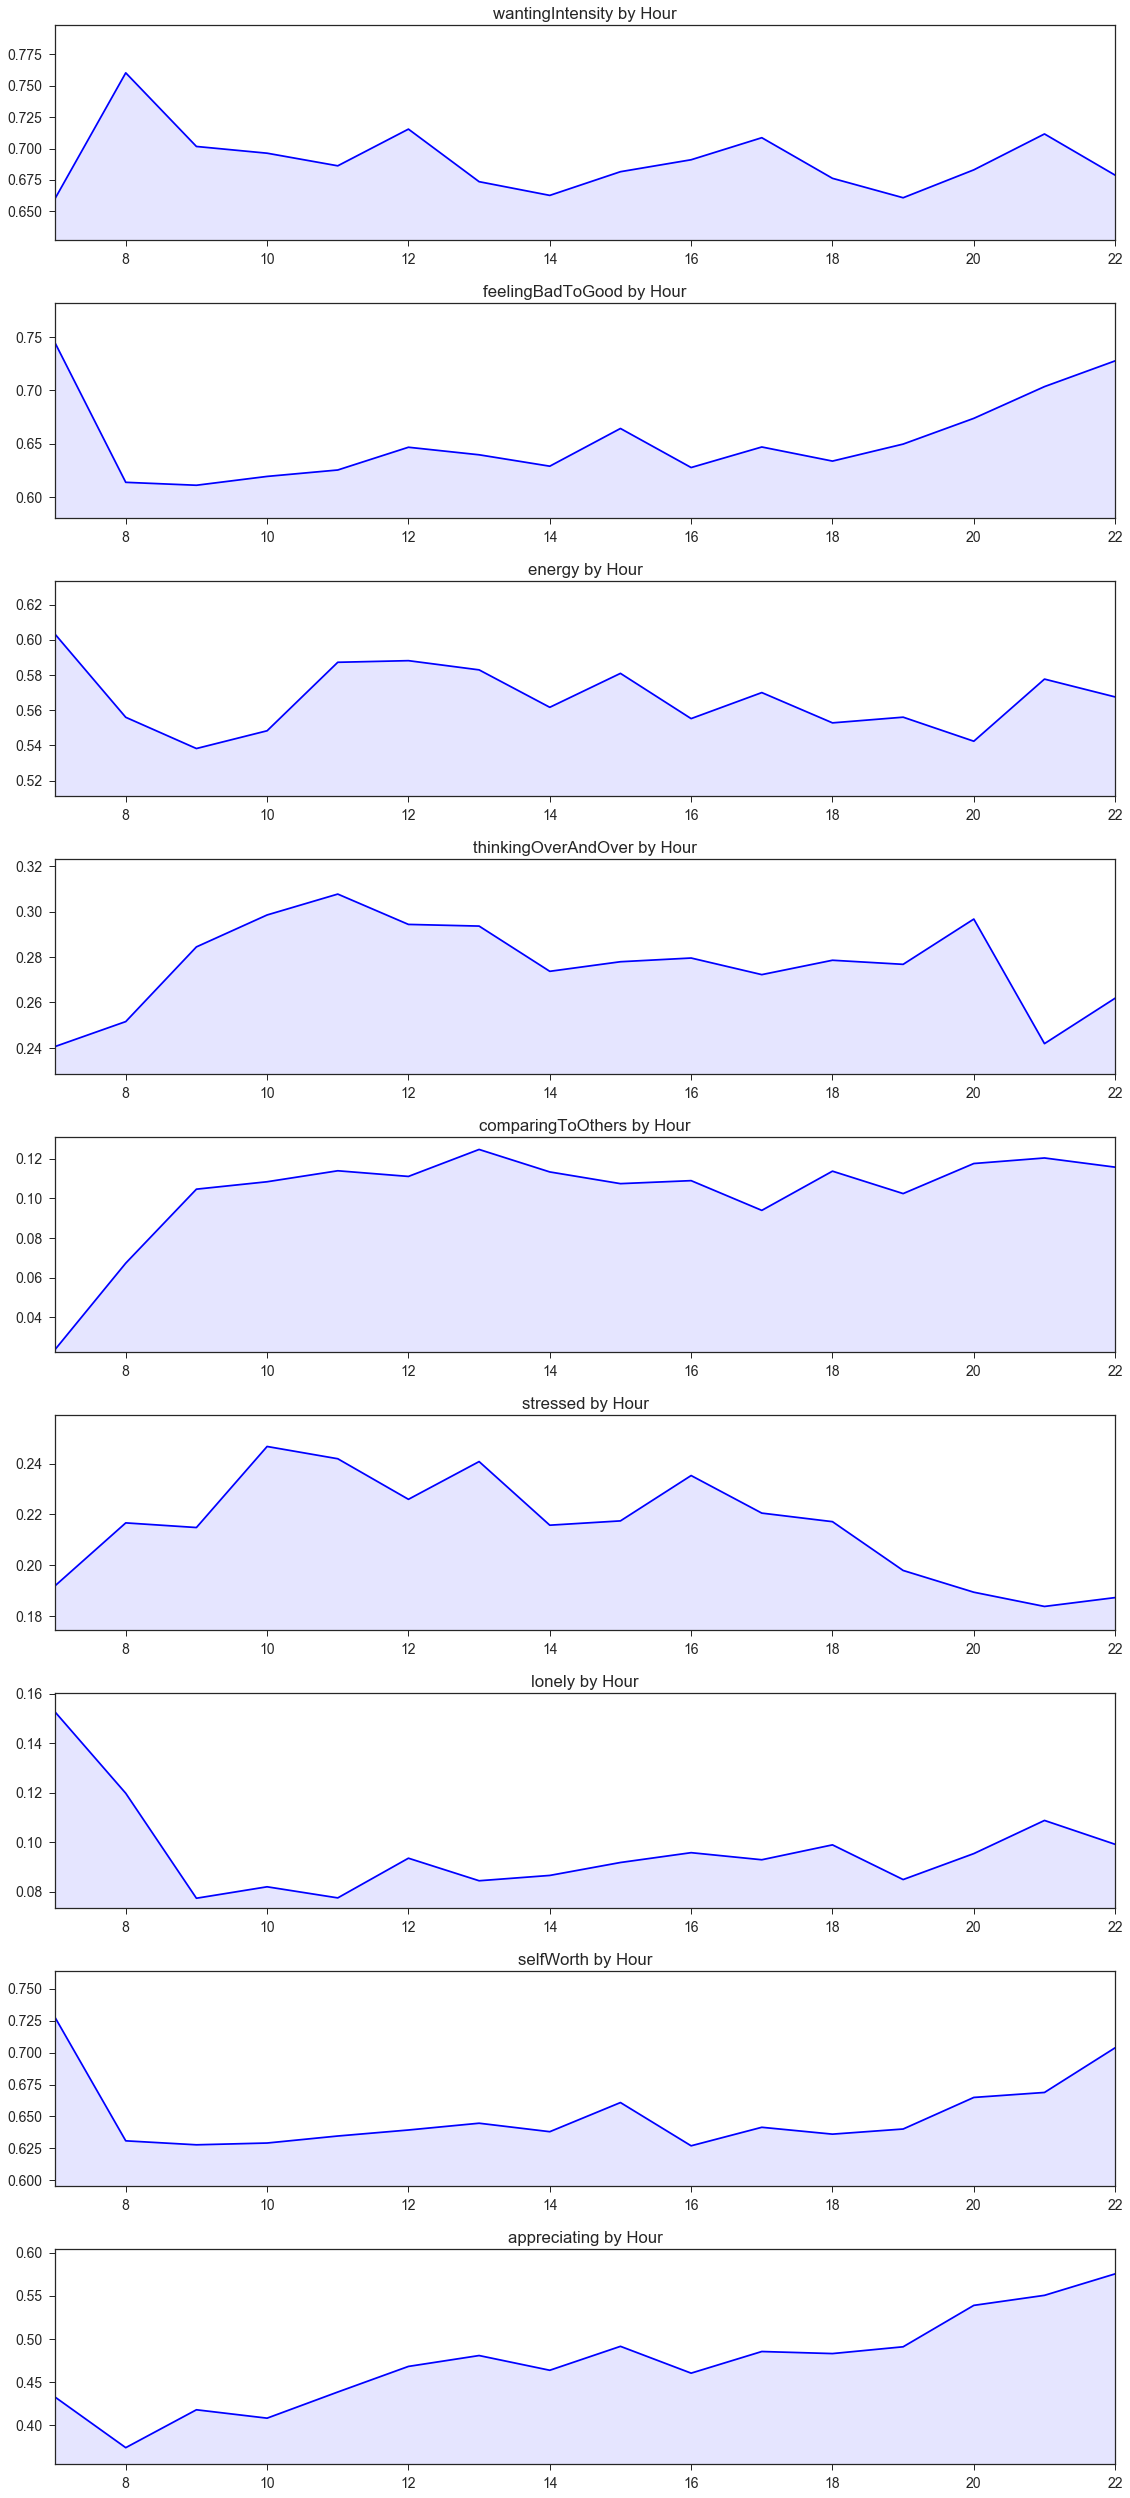

In [20]:
sns.set(font_scale=1.4, style='ticks')

plt.figure(figsize=(16,35))

for i in range(len(continuous_cols)):
    
    ax = plt.subplot(len(continuous_cols), 1, i+1)
    
    grouped = df.iloc[df[continuous_cols[i]].dropna(axis=0).index].groupby(by='hour')[continuous_cols[i]].mean()    
    grouped = grouped.iloc[5:-1] # Limit from 7 AM to 10 PM
    plt.plot(grouped.index.values, grouped.values, color='blue')
    
    plt.fill_between(x=grouped.index.values, y1=grouped.values, y2=0, facecolor='blue', alpha=0.1)
    
    plt.xlim((7,22))
    
    ylim_hi = grouped.max() * 1.05
    ylim_lo = grouped.min() * 0.95
    ax.set_ylim((ylim_lo, ylim_hi))
    
    plt.title('{} by Hour'.format(continuous_cols[i]))

plt.tight_layout()

plt.savefig('./images-esm/Continuous Variables By Hour 07-22h')

## Standardizing User Input Times

In [80]:
df.head(1)

row_id   user_id                                         record_id  \
0  464179  c2822848  4691a568625.a78f14cf-a990-44fc-9d26-8dd399dfd13d   

     recordReceived_ISO8601  recordReceived_secondsSinceMidnight1Jan1970UTC  \
0  2016-05-14T19:13:16.195Z                                      1463253196   

   previousResponsesOfTypeForUser   startTime_ISO8601  \
0                              16 2016-05-14 15:12:05   

   startTime_secondsSinceMidnight1Jan1970UTC  \
0                                 1463253125   

                               inResponseToAlert_id  \
0  4691a4bd5de.2b8d43d7-ebed-4a0d-aed1-6ae4c33514a7   

   estimatedSecondsSinceAlert  wantingAnything whatWanting  wantingIntensity  \
0                        63.0              0.0         NaN               NaN   

   wantedToFeel_pleasant  wantedToFeel_control  wantedToFeel_goodAboutMe  \
0                      0                     0                         0   

   wantedToFeel_connected  wantedToFeel_comfort  wantedToFeel_calm  \
0                       0                     0                  0   

   wantedToFeel_excited  wantedToFeel_competent  wantedToFeel_acknowledged  \
0                     0                       0                          0   

   wantedToFeel_alert  wantedToFeel_other wantedToFeel_specifiedOther  \
0                   0                   0                         NaN   

   wantedToFeel_nothingInParticular  doing           doing_specifiedOther  \
0                                 0  other  Relaxing with friends outside   

   withOthers  feelingBadToGood  energy  physically_hungry  physically_tired  \
0         2.0             0.882   0.498                  0                 0   

   physically_uncomfortable  physically_energized  physically_good  \
0                         0                     0                1   

   physically_other physically_specifiedOther  physically_noFeeling  \
0                 0                       NaN                     0   

   feeling_angry  feelingIntensity_angry  feeling_anxious  \
0              0                     NaN                0   

   feelingIntensity_anxious  feeling_awe  feelingIntensity_awe  \
0                       NaN            0                   NaN   

   feeling_compassion  feelingIntensity_compassion  feeling_content  \
0                   0                          NaN                1   

   feelingIntensity_content  feeling_enthusiastic  \
0                     0.598                     0   

   feelingIntensity_enthusiastic  feeling_grateful  feelingIntensity_grateful  \
0                            NaN                 1                      0.245   

   feeling_guilty  feelingIntensity_guilty  feeling_happy  \
0               0                      NaN              1   

   feelingIntensity_happy  feeling_resentful  feelingIntensity_resentful  \
0                   0.695                  0                         NaN   

   feeling_restless  feelingIntensity_restless  feeling_sad  \
0                 0                        NaN            0   

   feelingIntensity_sad  feeling_other feeling_specifiedOther  \
0                   NaN              0                    NaN   

   feeling_noEmotion  thinkingOverAndOver  comparingToOthers  lonely  \
0                  0                0.005              0.259   0.007   

   selfWorth  appreciating  stressed            endTime_ISO8601  \
0        0.5         0.998     0.042  2016-05-14T15:13:15-04:00   

   endTime_secondsSinceMidnight1Jan1970UTC  client  hour  dayofweek  
0                               1463253195       1    15          5

In [82]:
df2['user_id'] = df2['user_id'].apply(lambda x: x.split('.')[-1])
df2.head(1)

row_id   user_id                                         record_id  \
0  464475  3a96aab8  46949b48903.5e292a30-201a-498b-8885-641831741eab   

     recordReceived_ISO8601  recordReceived_secondsSinceMidnight1Jan1970UTC  \
0  2016-05-15T17:17:45.338Z                                      1463332665   

   previousResponsesOfTypeForUser          startTime_ISO8601  \
0                               0  2016-05-15T13:16:28-04:00   

   startTime_secondsSinceMidnight1Jan1970UTC  status pauseUntil  alertsPerDay  \
0                                 1463332588  active        NaN             7   

   weekdayFrom weekdayTo weekendFrom weekendTo alertSound originalAlertSound  \
0           12     00:00       10:00     22:00   longbell           longbell   

   stopReason_bored  stopReason_busy  stopReason_notData  stopReason_other  \
0               NaN              NaN                 NaN               NaN   

   stopComment            endTime_ISO8601  \
0          NaN  2016-05-15T13:17:44-04:00   

   endTime_secondsSinceMidnight1Jan1970UTC  
0                               1463332664

In [54]:
print len(set([user_id.split('.')[-1] for user_id in df2['user_id'].unique()]))
print len(df['user_id'].unique())

352
95


In [79]:
df2['weekdayFrom'].unique()

array([12,  6,  9,  8, 11, 14,  5,  1, 10, 15, 13,  7,  4, 23, 16, 22])

In [78]:
df2['weekdayFrom'] = pd.to_datetime(df2['weekdayFrom'], format='%H:%M').dt.hour
df2['weekdayTo'] = pd.to_datetime(df2['weekdayTo'], format='%H:%M').dt.hour
df2['weekdendFrom'] = pd.to_datetime(df2['weekendFrom'], format='%H:%M').dt.hour
df2['weekendTo'] = pd.to_datetime(df2['weekendTo'], format='%H:%M').dt.hour

ValueError: time data '24:00' does not match format '%H:%M' (match)

For each entry, we need:
1. The timestamp for the entry 
2. The weekdayFrom/weekendFrom hour value for that particular user
3. To create a datetime using the weekdayFrom/weekendFrom hour value, and the day value for the entry
4. Find the delta between 1. and 3. - This is the standardized timestamp value for that entry


In [84]:
df['user_id'].unique()[0]

'c2822848'

In [88]:
df2[df2['user_id'] == df['user_id'].unique()[0]].loc[df2['status']=='active','weekdayFrom']

657    9
Name: weekdayFrom, dtype: int64

In [133]:
for user in df['user_id'].unique():
    print df2[df2['user_id'] == user].loc[df2['status']=='active','weekdayFrom'].iloc[0] 

9
9
5
9
9
9
10
12
9
9
9
11
8
9
14
9
8
9
8
11
9
10
10
8
9
10
10
9
7
8
10
8
10
9
4
8
11
10
9
9
9
7
8
9
10
10
9
8
12
9
11
8
9
12
8
11
11
7
9
9
9
9
8
8
9
10
8
9
10
9
8
8
9
10
9
9
7
9
9
10
10
9
9
10
9
7
10
8
12
11
9
9
8
9
9


In [160]:
def standardize_timestamp(x, dayFlag=1):
    ts = x['startTime_ISO8601']
    day = ts.day
    dayofweek = ts.dayofweek
    hour = ts.hour
    weekdayFromHour = df2[df2['user_id'] == x['user_id']].loc[df2['status']=='active','weekdayFrom'].iloc[0]
    weekendFromHour = df2[df2['user_id'] == x['user_id']].loc[df2['status']=='active','weekendFrom'].iloc[0]
    
    
    if dayofweek >= 1 and dayofweek <= 5: # if weekday
        # If the current ts hour is < weekdayFrom hour, then the weekdayFrom day = ts.day - 1
        if hour < weekdayFromHour:
            fromDay = day - 1
        else:     
            fromDay = day
        fromHour = weekdayFromHour
    else: 
        if hour < weekendFromHour:
            fromDay = day - 1
        else:     
            fromDay = day
        fromHour = weekendFromHour
    
    if isinstance(fromHour, str):
        fromHour = int(fromHour.split(':')[0])
        
    # Build timestamp using FromDay and FromHour
#     print ts.year, ts.month, fromDay, fromHour 
    fromTs = datetime(year=ts.year, month=ts.month, day=fromDay, hour=fromHour)
    
    td = ts - fromTs
    
    if dayFlag:
        return td.days
    else:
        return td.seconds//3600
    
    

    

In [157]:
df['hour_standardized'] = df.apply(standardize_timestamp, axis=1)

In [161]:
df['day_standardized'] = df.apply(standardize_timestamp, axis=1,)

In [163]:
df['hour_standardized'].unique()

array([ 6, 10,  7,  8, 13,  9, 11, 12,  1,  0,  2,  4,  3,  5, 23, 22, 20,
       21, 14, 15])

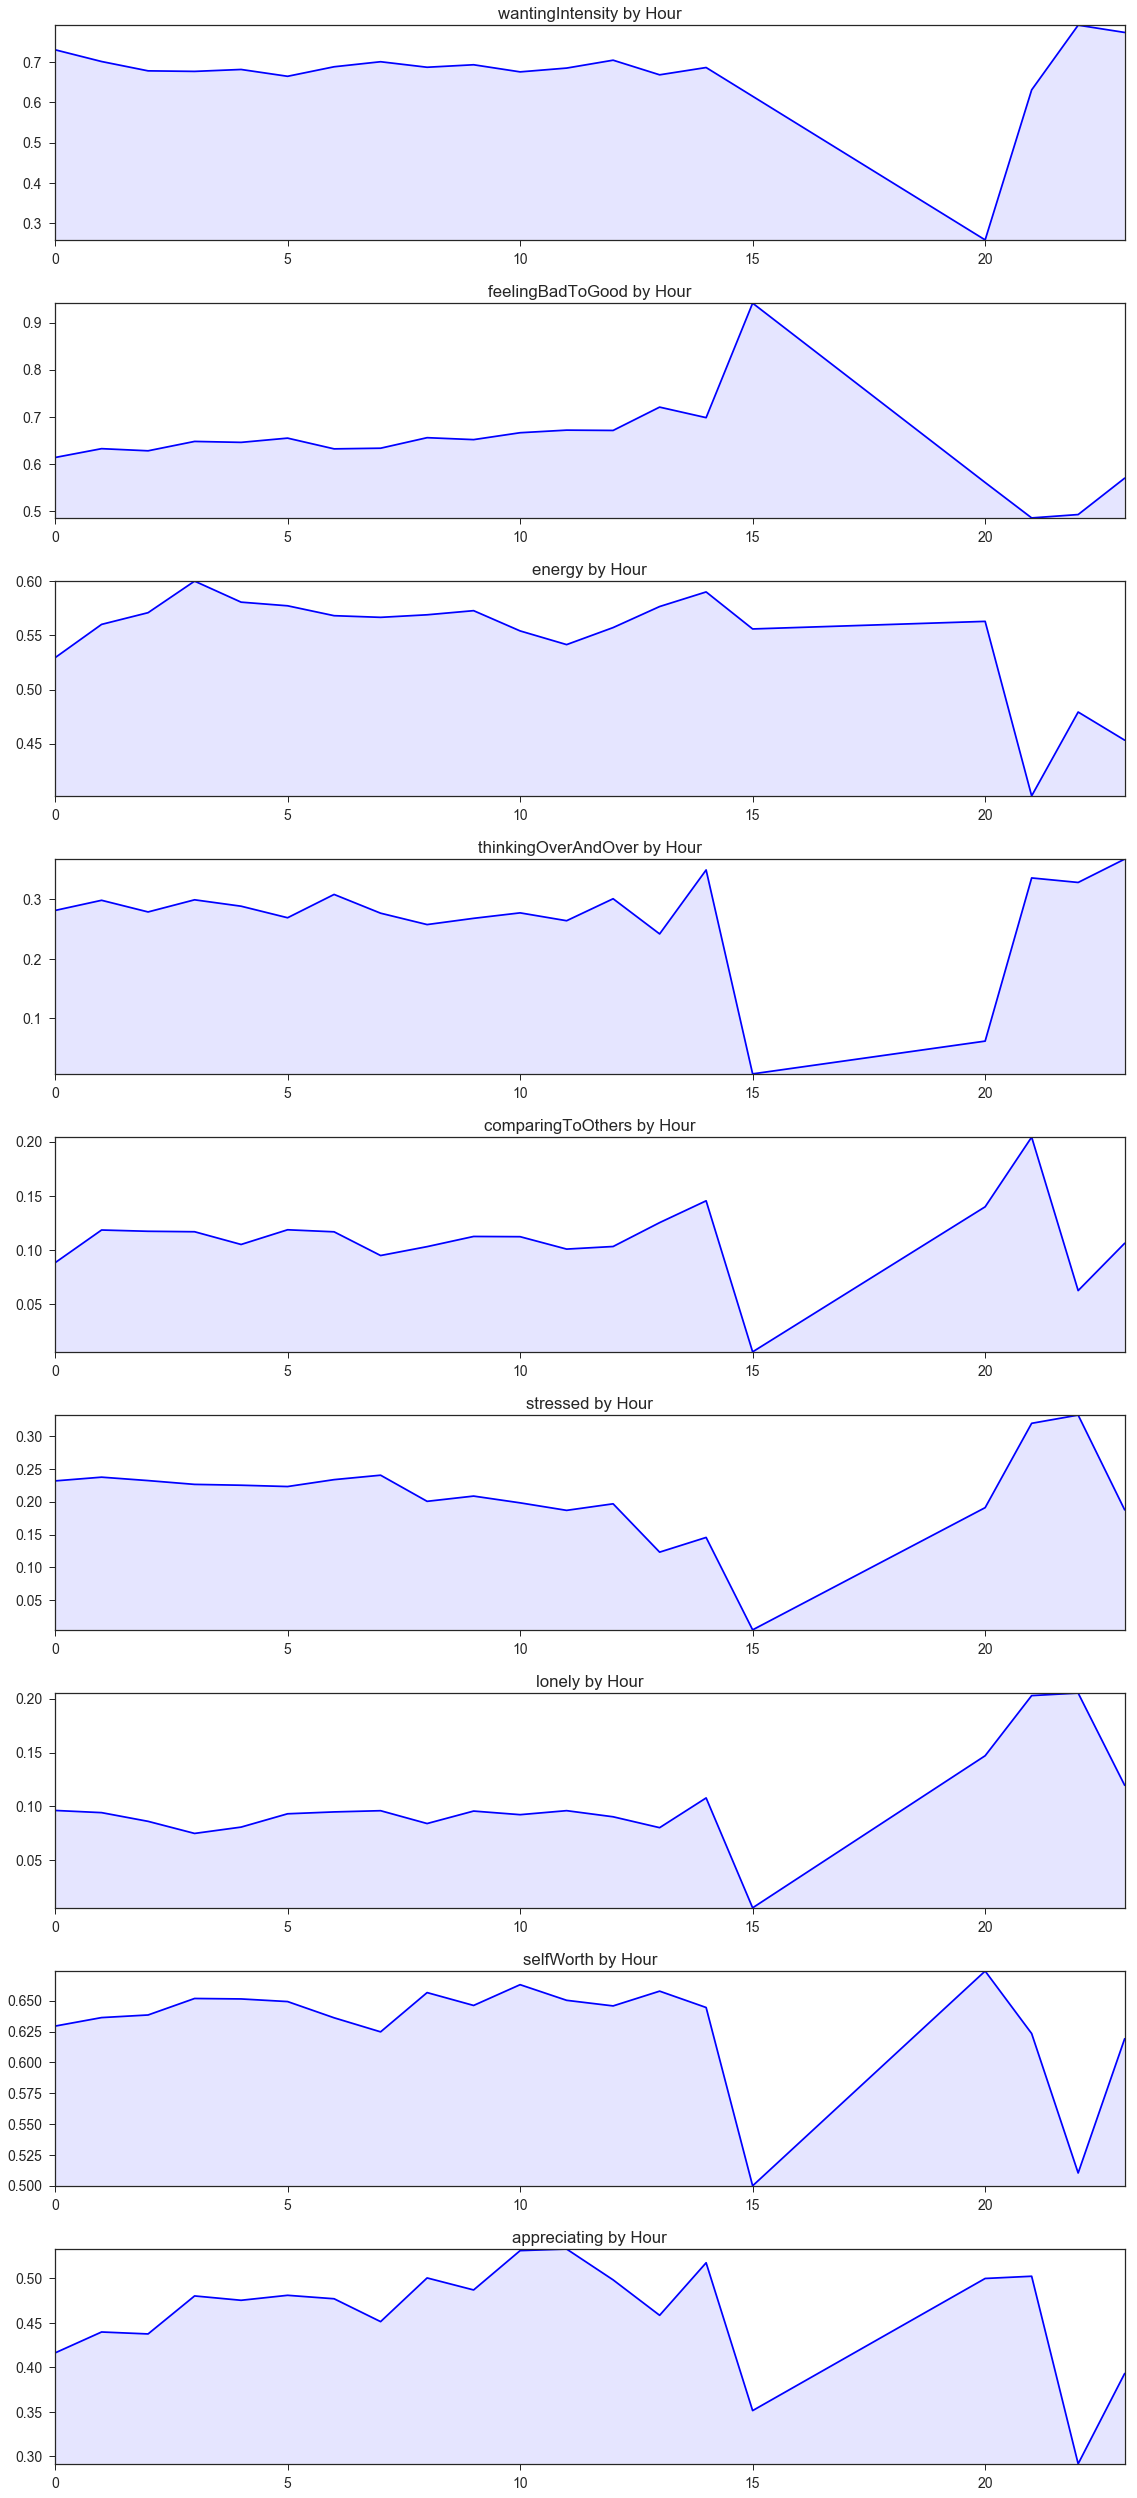

In [162]:
sns.set(font_scale=1.4, style='ticks')

plt.figure(figsize=(16,35))

for i in range(len(continuous_cols)):
    
    ax = plt.subplot(len(continuous_cols), 1, i+1)
    
    grouped = df.iloc[df[continuous_cols[i]].dropna(axis=0).index].groupby(by='hour_standardized')[continuous_cols[i]].mean()
    plt.plot(grouped.index.values, grouped.values, color='blue')
    
    plt.fill_between(x=grouped.index.values, y1=grouped.values, y2=np.min(grouped.values), facecolor='blue', alpha=0.1)
    
    plt.xlim((0,23))
    
    ylim_hi = grouped.max() #* 1.2
    ylim_lo = grouped.min() #* 0.8
#     ax = plt.gca()
    ax.set_ylim((ylim_lo, ylim_hi))
#     ax.set_ylim((0.6, 0.8))
    
    plt.title('{} by Hour'.format(continuous_cols[i]))

plt.tight_layout()

# plt.savefig('./images-esm/Continuous Variables By Hour 00-23h')

## Daily Averages for Continuous Variables
---

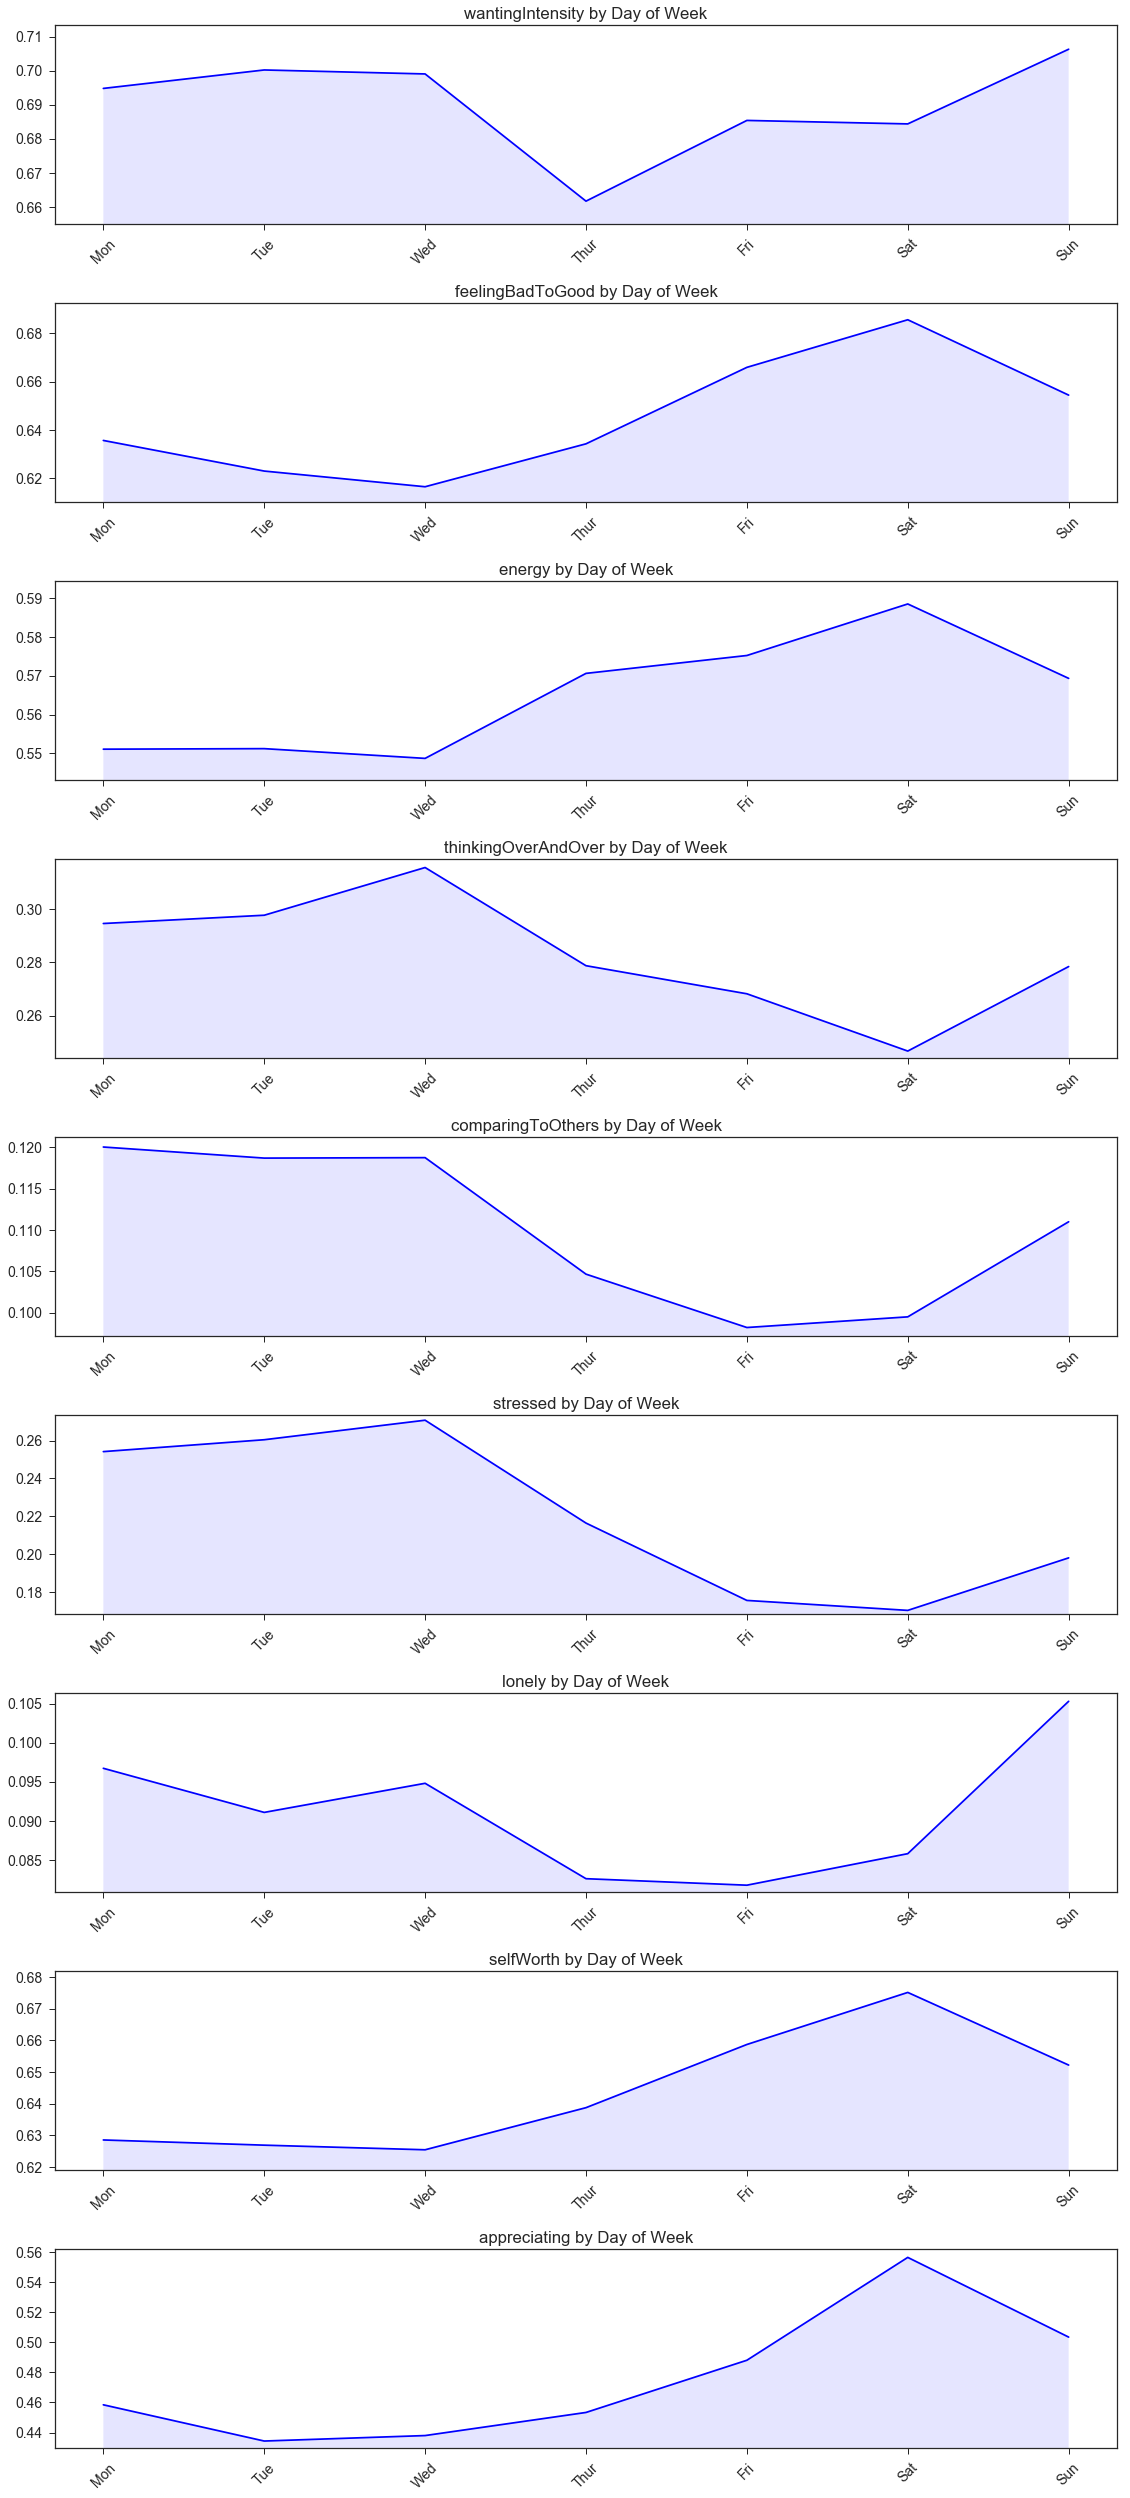

In [21]:
plt.figure(figsize=(16,35))

sns.set(font_scale=1.4, style='ticks')

for i in range(len(continuous_cols)):
    
    ax = plt.subplot(len(continuous_cols), 1, i+1)
    
    grouped = df.iloc[df[continuous_cols[i]].dropna(axis=0).index].groupby(by='dayofweek')[continuous_cols[i]].mean()
    plt.plot(grouped.index.values, grouped.values, color='blue')

    ylim_hi = grouped.max() * 1.01
    ylim_lo = grouped.min() * 0.99
    ax.set_ylim((ylim_lo, ylim_hi))
    
    plt.fill_between(x=grouped.index.values, y1=grouped.values, y2=0, facecolor='blue', alpha=0.1)
    
    plt.xticks(grouped.index.values, labels, rotation=45)
    
    plt.title('{} by Day of Week'.format(continuous_cols[i]))
    
plt.tight_layout()

plt.savefig('./images-esm/Continuous Variables By Day of Week')

### Bar Graphs

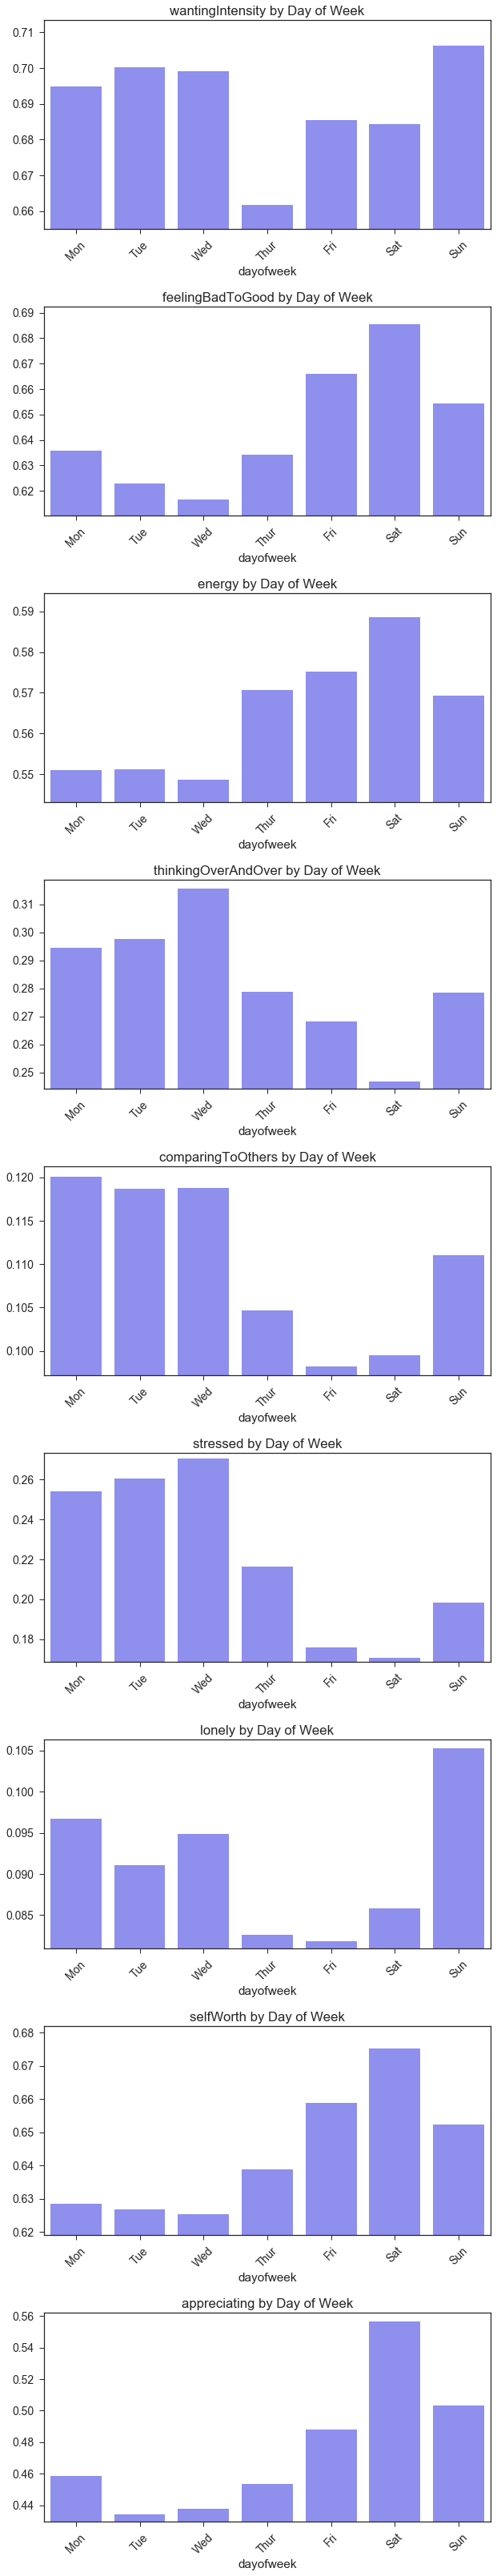

In [22]:
plt.figure(figsize=(9,45))

sns.set(font_scale=1.4, style='ticks')

for i in range(len(continuous_cols)):
    
    ax = plt.subplot(len(continuous_cols), 1, i+1)
    
    grouped = df.iloc[df[continuous_cols[i]].dropna(axis=0).index].groupby(by='dayofweek')[continuous_cols[i]].mean()
    
    ax = sns.barplot(x=grouped.index, y=grouped.values, color='blue', alpha=0.5)

    ylim_hi = grouped.max() * 1.01
    ylim_lo = grouped.min() * 0.99
    ax.set_ylim((ylim_lo, ylim_hi))
    
    plt.xticks(grouped.index.values, labels, rotation=45)
    
    plt.title('{} by Day of Week'.format(continuous_cols[i]))
    
plt.tight_layout()

plt.savefig('./images-esm/Continuous Variables By Day of Week Bar Chart')

## 3. Frequencies of Categorical Variables as Stacked Line Chart
---

In [24]:
grouped = df[['hour'] + wanted_to_feel_cols + ['wantedToFeel_noOptionSelected']].groupby(by='hour').sum()

summed = grouped.sum(axis=1)

In [25]:
# Drop any columns that are 0 
grouped = grouped.loc[:, (grouped != 0).any(axis=0)]

# Sum columns 
grouped = grouped.iloc[:,:].div(summed, axis=0)

grouped = grouped.iloc[1:,:]

grouped_summed = grouped

for i in range(1,len(grouped_summed.columns)):
    grouped_summed.iloc[:, i] += grouped_summed.iloc[:, i-1]

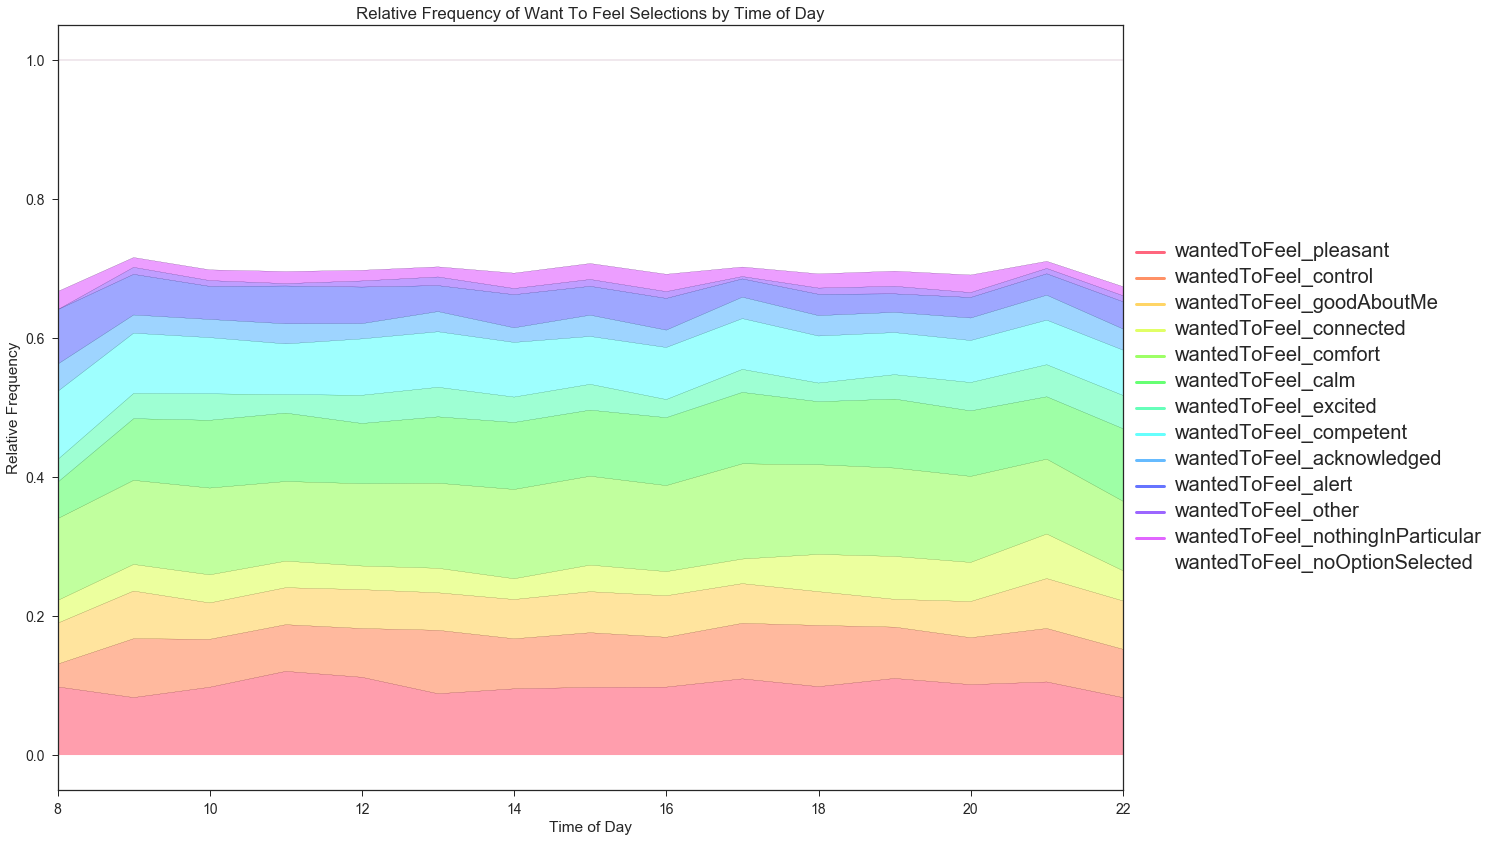

In [26]:
fig, ax = plt.subplots(figsize=(16,12))

color = iter(plt.cm.gist_rainbow(np.linspace(0,1,len(grouped_summed.columns))))

for i in range(len(grouped_summed.columns)):
    
    c = next(color)
    
    label = grouped_summed.iloc[:, i].name

    ls = '-'
    lw = 0.15
    ax.plot(grouped_summed.index.values, grouped_summed.iloc[:, i].values, color=c, label=label, ls=ls, lw=0.1, alpha=0.6, visible=True)
    ax.plot(grouped_summed.index.values, grouped_summed.iloc[:, i].values, color='black', ls=ls, lw=lw, alpha=0.8, visible=True)

    
    alpha = 0.38
    if i == 0:
        ax.fill_between(x=grouped_summed.index.values, y1=grouped_summed.iloc[:, i].values, y2=0, facecolor=c, alpha=alpha)    
    elif i==len(grouped_summed.columns)-1:
        ax.fill_between(x=grouped_summed.index.values, y1=grouped_summed.iloc[:, i].values, y2=grouped_summed.iloc[:, i-1].values, facecolor='white', alpha=alpha)
    else:
        ax.fill_between(x=grouped_summed.index.values, y1=grouped_summed.iloc[:, i].values, y2=grouped_summed.iloc[:, i-1].values, facecolor=c, alpha=alpha)
    
ax.set_xlim((8,22))

ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Time of Day')    
ax.set_title('Relative Frequency of Want To Feel Selections by Time of Day')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

frame = legend.get_frame()

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for i,legobj in enumerate(legend.legendHandles):
    legobj.set_linewidth(3.0)
    if i == len(grouped_summed.columns)-1:
        legobj.set_color('white')

fig.tight_layout()

plt.savefig('./images-esm/want_to_feel_relative_frequency_by_hour', bbox_extra_artists=(legend,), bbox_inches='tight')


### Relative Frequency of Want to Feel by Day of Week

In [27]:
grouped = df[['dayofweek'] + wanted_to_feel_cols + ['wantedToFeel_noOptionSelected']].groupby(by='dayofweek').sum()

summed = grouped.sum(axis=1)

grouped = grouped.loc[:, (grouped != 0).any(axis=0)]

grouped = grouped.iloc[:,:].div(summed, axis=0)

grouped_summed = grouped

for i in range(1,len(grouped_summed.columns)):
    grouped_summed.iloc[:, i] += grouped_summed.iloc[:, i-1]

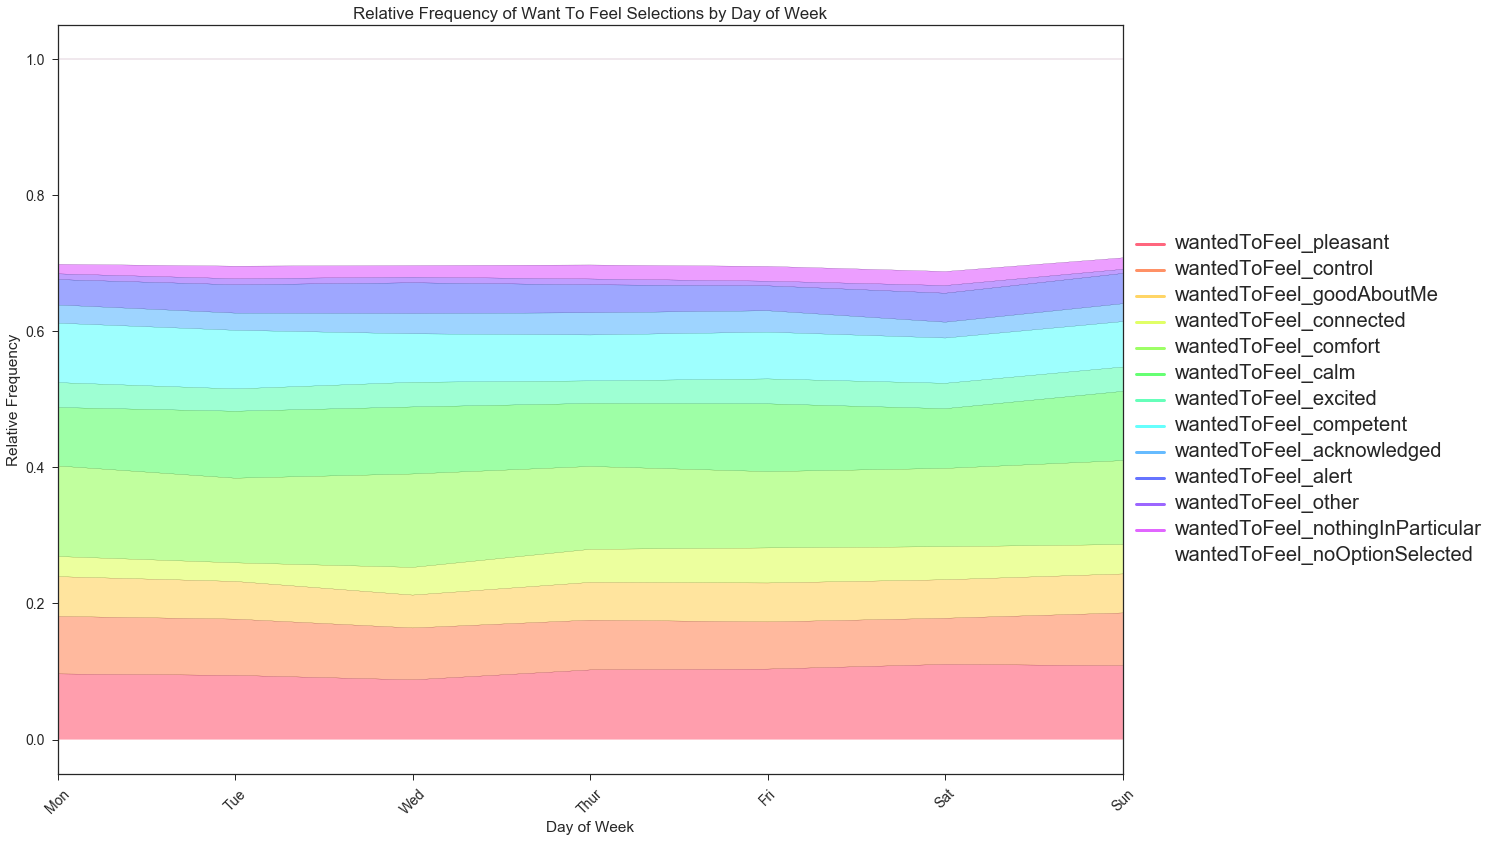

In [28]:
fig, ax = plt.subplots(figsize=(16,12))

color = iter(plt.cm.gist_rainbow(np.linspace(0,1,len(grouped_summed.columns))))

labels = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']

for i in range(len(grouped_summed.columns)):
    
    c = next(color)
    
    label = grouped_summed.iloc[:, i].name

    ls = '-'
    lw = 0.15
    ax.plot(grouped_summed.index.values, grouped_summed.iloc[:, i].values, color=c, label=label, ls=ls, lw=0.1, alpha=0.6, visible=True)
    ax.plot(grouped_summed.index.values, grouped_summed.iloc[:, i].values, color='black', ls=ls, lw=lw, alpha=0.8, visible=True)

    
    alpha = 0.38
    if i == 0:
        ax.fill_between(x=grouped_summed.index.values, y1=grouped_summed.iloc[:, i].values, y2=0, facecolor=c, alpha=alpha)    
    elif i==len(grouped_summed.columns)-1:
        ax.fill_between(x=grouped_summed.index.values, y1=grouped_summed.iloc[:, i].values, y2=grouped_summed.iloc[:, i-1].values, facecolor='white', alpha=alpha)
    else:
        ax.fill_between(x=grouped_summed.index.values, y1=grouped_summed.iloc[:, i].values, y2=grouped_summed.iloc[:, i-1].values, facecolor=c, alpha=alpha)
    
ax.set_xlim((0,1))
ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Day of Week')    
ax.set_title('Relative Frequency of Want To Feel Selections by Day of Week')

plt.xticks(grouped_summed.index.values, labels, rotation=45)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

frame = legend.get_frame()

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for i,legobj in enumerate(legend.legendHandles):
    legobj.set_linewidth(3.0)
    if i == len(grouped_summed.columns)-1:
        legobj.set_color('white')

fig.tight_layout()

plt.savefig('./images-esm/want_to_feel_relative_frequency_by_day', bbox_extra_artists=(legend,), bbox_inches='tight')

# Aggregations
---

In [29]:
def get_feeling_type(row):
    for c in feeling_type_cols:
        if row[c] == 1:
            return c

In [30]:
df['feelingType'] = df.apply(get_feeling_type, axis=1)

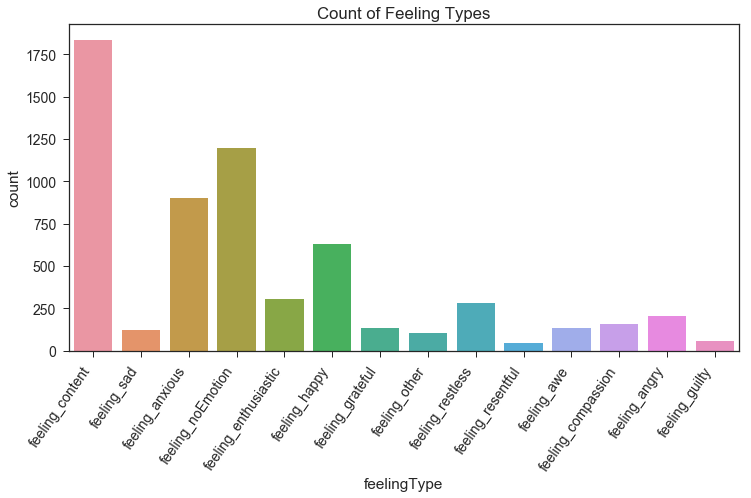

In [31]:
plt.figure(figsize=(12,6))

sns.set(font_scale=1.4, style='ticks')

g = sns.countplot(df[~df['feelingType'].isnull()].loc[:,'feelingType'])

plt.xticks(rotation=55, horizontalalignment='right')
plt.title('Count of Feeling Types')

plt.savefig('./images-esm/Count of Feeling Types.png')

# Correlations

### Find Correlation Between Continuous Variables

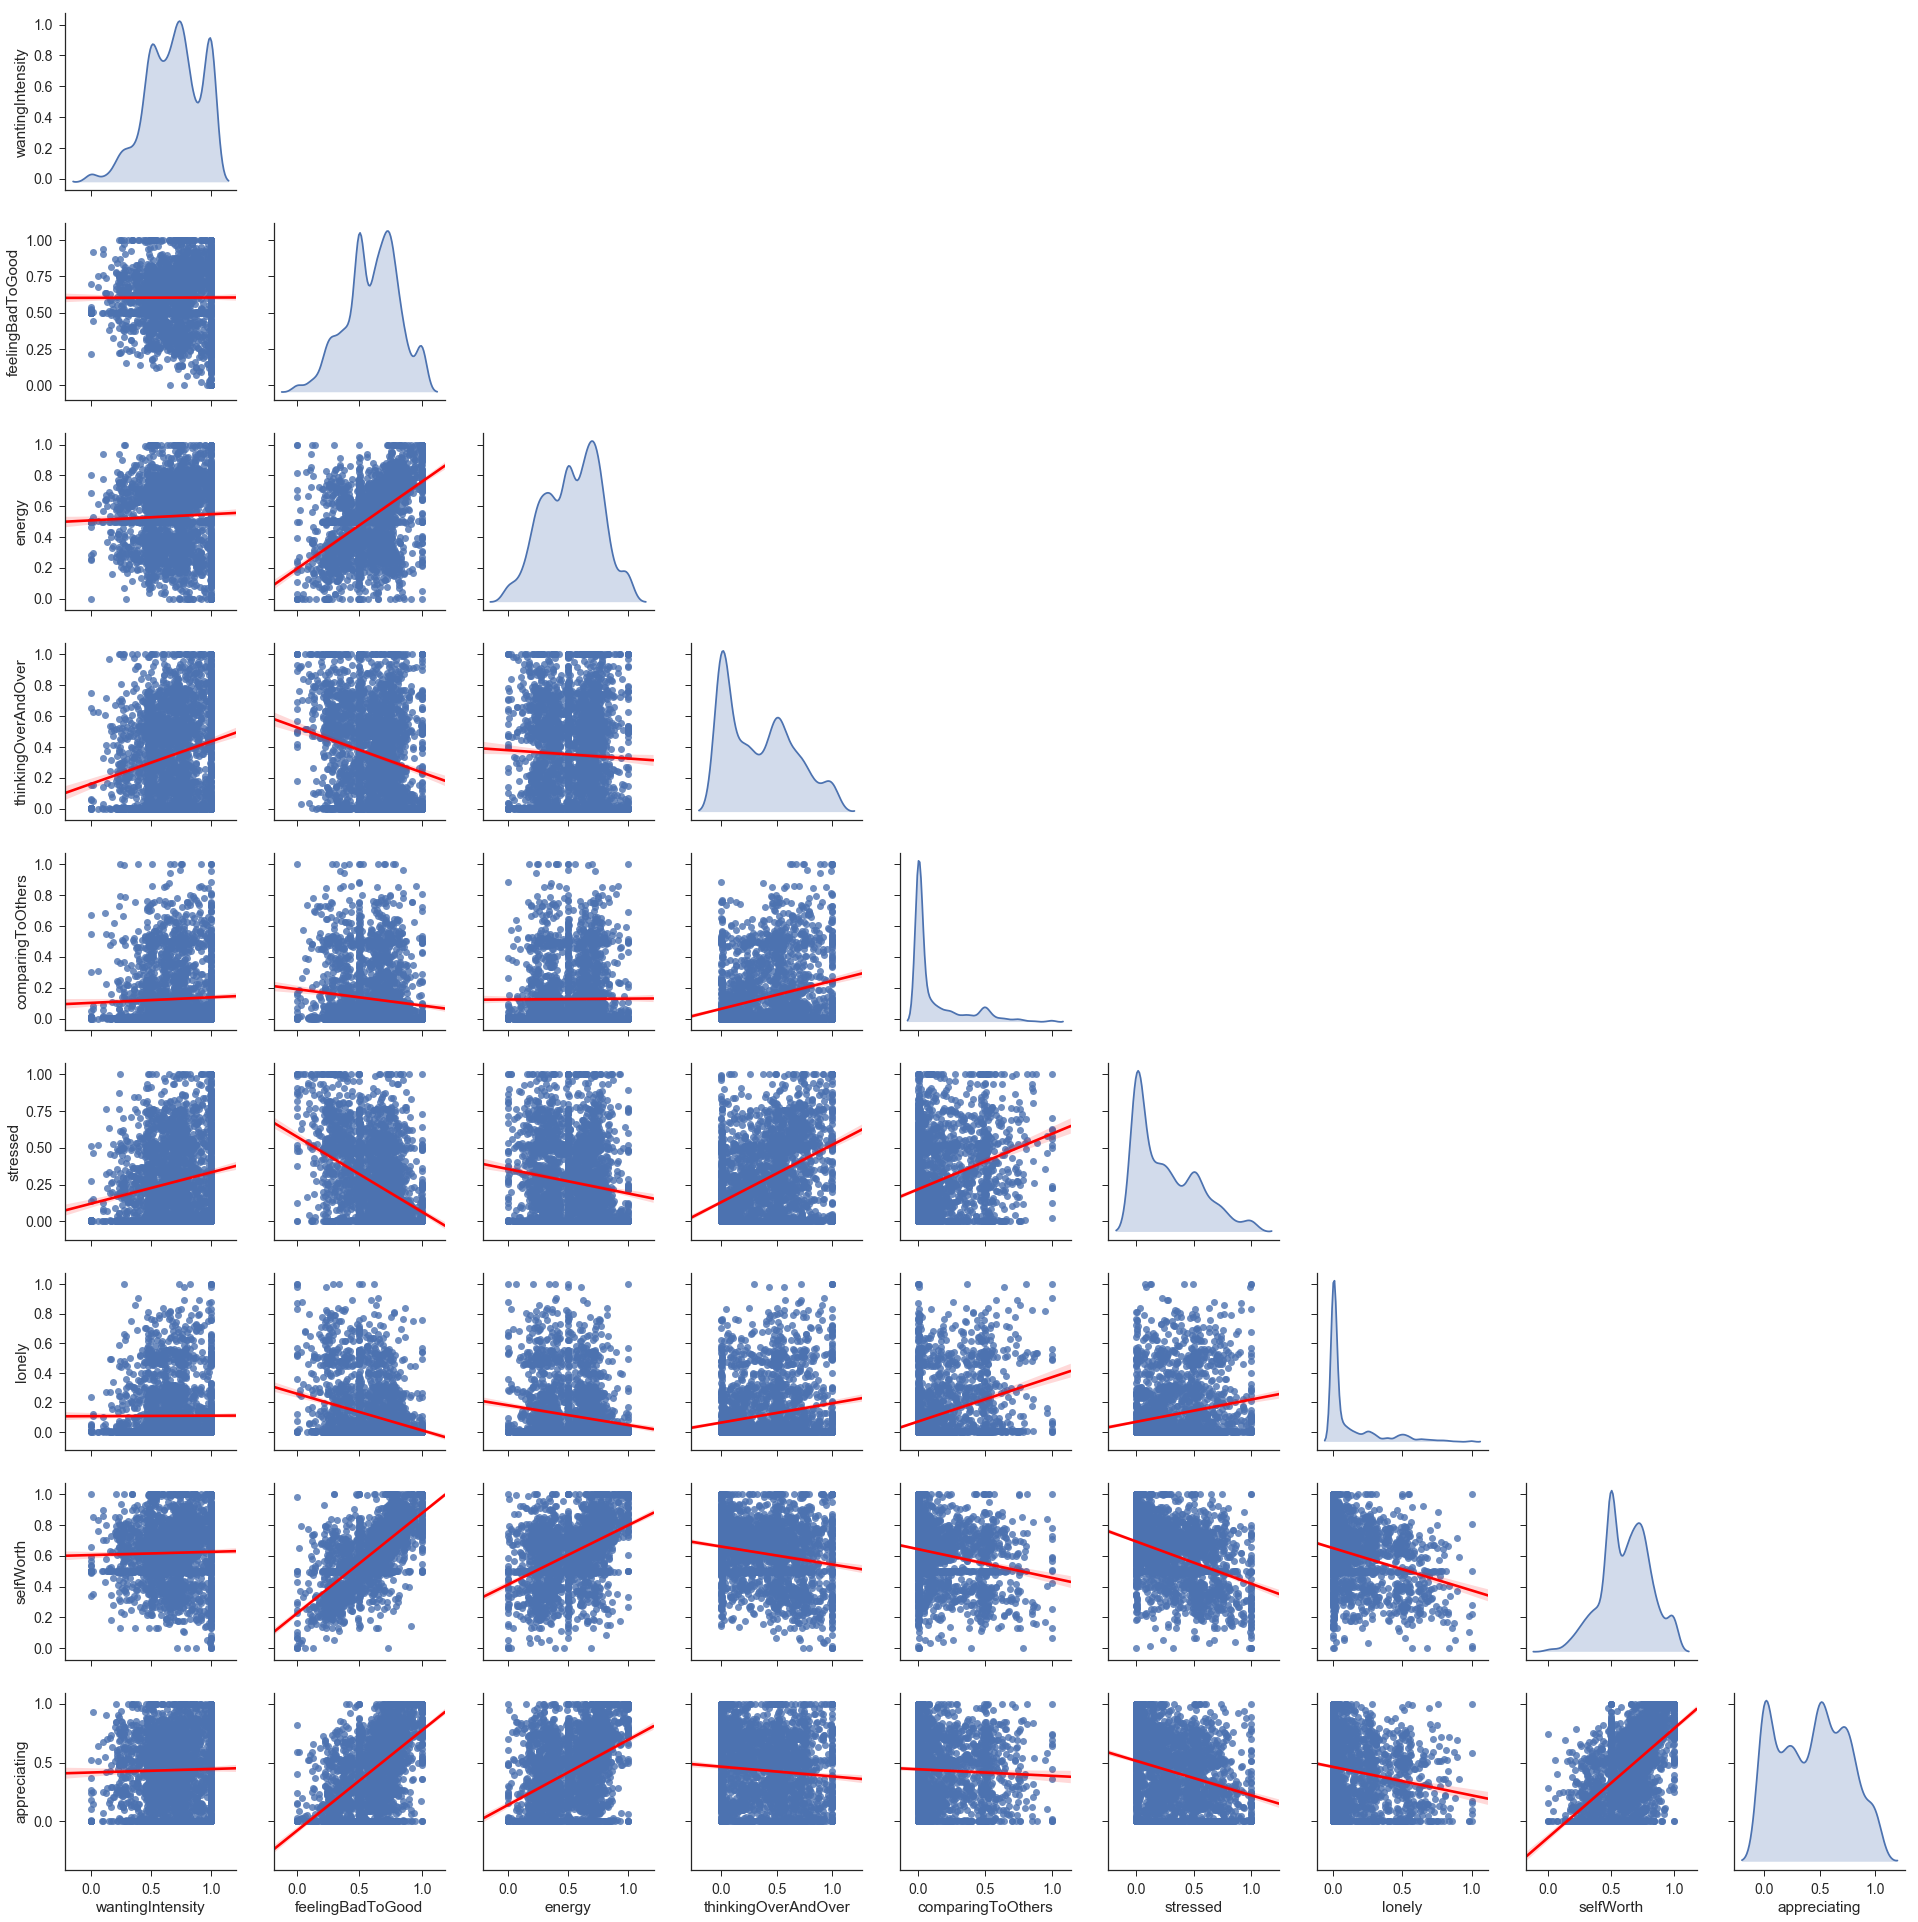

In [32]:
plt.figure(figsize=(17,40))

sns.set(font_scale=1.4)

with sns.axes_style( style="ticks"):
    g = sns.pairplot(df[continuous_cols].dropna(axis=0), kind="reg", diag_kind='kde', size=3, \
                     diag_kws=dict(shade=True), \
                    plot_kws={'line_kws':{'color':'red'}})
    
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i,j].set_visible(False)

plt.savefig('./images-esm/Relationships between Continuous Variables.png')

### Scatter plot of the average Intensity of Want vs. Energy for each activity

In [18]:
# Don't use rows that have 0 wanting, aka drop rows with null values in 'wantingIntensity'
dfc = df[pd.notnull(df['wantingIntensity'])]

# Need to make 2 dataframes, one that is the average intensity of want and average energy grouped by activity
df2 = pd.concat(objs=[dfc['wantingIntensity'], dfc['energy'],dfc['doing']], axis=1)

grouped_means = df2.groupby(by='doing').mean()

# Other dataframe is the frequency count of each activity 
grouped_count = pd.concat(objs=[dfc['doing'],pd.get_dummies(data=dfc['doing'])], axis=1, names=['count']).groupby(by='doing').count().iloc[:,0]

grouped_count.name = 'count'

df2 = pd.concat(objs=[grouped_means, grouped_count], axis=1)

df2['count'] = df2['count'] / df2['count'].sum()

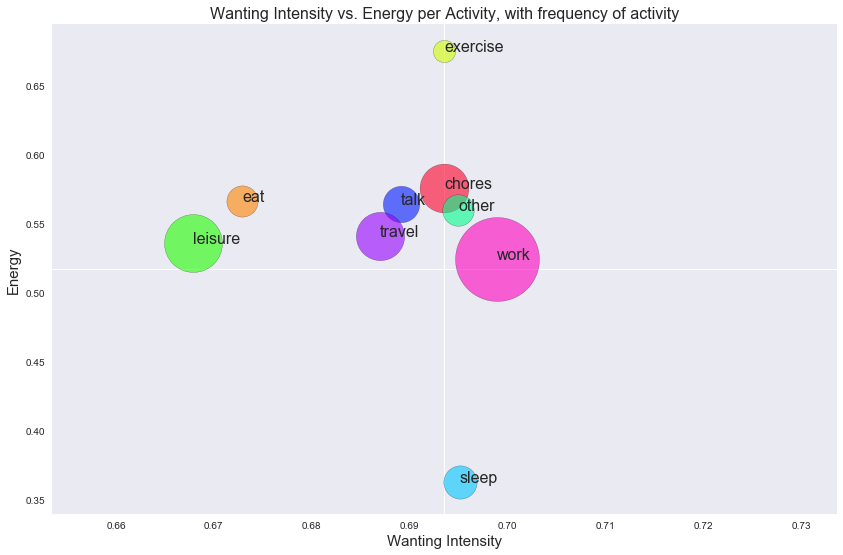

In [41]:
s = [x*20000 for x in df2['count'].values]

c = plt.cm.gist_rainbow(np.linspace(0,1,len(df2.index)))

sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(df2.index.values.tolist())):

    x = df2['wantingIntensity'].values[i]
    y = df2['energy'].values[i]
    ind = df2.index.values[i]

    ax.scatter(x, y, s=s[i], c=c[i], alpha=0.6, label=ind, edgecolors='black')

    ax.annotate(s=ind, xy=(x,y), )

plt.xlabel('Wanting Intensity', fontsize=15)
plt.ylabel('Energy', fontsize=15)
plt.title('Wanting Intensity vs. Energy per Activity, with frequency of activity', fontsize=16)

mid_y = (plt.ylim()[0] + plt.ylim()[1]) / 2
mid_x = (plt.xlim()[0] + plt.xlim()[1]) / 2

ax.set_yticks([mid_y], minor=True)
ax.set_xticks([mid_x], minor=True)
ax.yaxis.grid(True, which='minor')
ax.xaxis.grid(True, which='minor')
        
# Set font size of circle text
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}    
plt.rc('font', **font)

plt.grid(False)

fig.tight_layout()

plt.savefig('./images-esm/intensity_of_want_vs_energy_for_each_activity.png', \
            bbox_inches='tight')

**General Function for cont. variable vs. want intensity, w/ doing freq**
<br>will need to filter out null wantingIntensity for this one

In [ ]:
wanted_to_feel_cols.remove('wantedToFeel_specifiedOther')

In [218]:
def create_frequency_scatter_plot(average_type='mean', \
                                  xaxis_var='energy', \
                                  yaxis_var='wantingIntensity', \
                                  circle_var='doing'):
    
    
    # ---- Pre-process the data
    # Don't use rows that have 0 wanting, aka drop rows with null values in 'wantingIntensity'
    dfc = df[pd.notnull(df['wantingIntensity'])]

        
    # Other dataframe is the frequency count of each activity 
    if circle_var == 'doing':
        # Need to make 2 dataframes, one that is the average intensity of want and average energy grouped by activity
        df2 = pd.concat(objs=[dfc[yaxis_var], dfc[xaxis_var], dfc[circle_var]], axis=1)
        
        if average_type=='mean':
            grouped_means = df2.groupby(by='doing').mean() 
        elif average_type=='median':
            grouped_means = df2.groupby(by='doing').median() 
        
        grouped_count = pd.concat(objs=[dfc[circle_var],pd.get_dummies(data=dfc[circle_var])], axis=1, names=['count'])\
                        .groupby(by='doing')\
                        .count()\
                        .iloc[:,0]
        grouped_count.name = 'count'
        df2 = pd.concat(objs=[grouped_means, grouped_count], axis=1)
        df2['count'] = df2['count'] / df2['count'].sum() # convert count column to %
    elif circle_var == 'want_to_feel': 
        temp = dfc.copy()
        temp.set_index(keys='row_id', drop=True, inplace=True)
        temp = temp[wanted_to_feel_cols].stack().reset_index()
        temp.rename(columns={0:'count', 'level_1':'category'}, inplace=True)
        y = temp['row_id'].map(dfc[['row_id',yaxis_var]].set_index('row_id', drop=True).squeeze())
        y.name = yaxis_var
        x = temp['row_id'].map(dfc[['row_id',xaxis_var]].set_index('row_id', drop=True).squeeze())
        x.name = xaxis_var
        temp = pd.concat(objs=[temp,x,y], axis=1)
        count = temp[temp['count']!=0].loc[:, ['category','count']].groupby(by='category').count()
        count['count'] = count['count'] / count['count'].sum()
        if average_type=='mean':
            x = temp[temp['count']!=0].loc[:, ['category',xaxis_var]].groupby(by='category').mean()
            y = temp[temp['count']!=0].loc[:, ['category',yaxis_var]].groupby(by='category').mean()
        elif average_type=='median':
            x = temp[temp['count']!=0].loc[:, ['category',xaxis_var]].groupby(by='category').median()
            y = temp[temp['count']!=0].loc[:, ['category',yaxis_var]].groupby(by='category').median()
        df2 = pd.concat(objs=[x,y,count], axis=1)

    
    # ---- Create the plot 
    s = [x*20000 for x in df2['count'].values] # scaling size of the circle by count * 20,000- that makes an OK size.

    c = plt.cm.gist_rainbow(np.linspace(0,1,len(df2.index))) # for coloring the circles appropriately

    sns.set_style('darkgrid')

    fig, ax = plt.subplots(figsize=(12,8))

    for i in range(len(df2.index.values.tolist())):

        x = df2[yaxis_var].values[i]
        y = df2[xaxis_var].values[i]
        circle_label = df2.index.values[i]

        ax.scatter(x, y, s=s[i], c=c[i], alpha=0.6, label=circle_label, edgecolors='black')

        ax.annotate(s=circle_label, xy=(x,y), )

    plt.xlabel(yaxis_var, fontsize=16)
    plt.ylabel(xaxis_var, fontsize=16)
    plt.title('{} of {} vs. {} of {}, with frequency of {}'.format(average_type, average_type, yaxis_var, xaxis_var, circle_var), fontsize=16)

    mid_y = (plt.ylim()[0] + plt.ylim()[1]) / 2
    mid_x = (plt.xlim()[0] + plt.xlim()[1]) / 2

    ax.set_yticks([mid_y], minor=True)
    ax.set_xticks([mid_x], minor=True)
    ax.yaxis.grid(True, which='minor')
    ax.xaxis.grid(True, which='minor')

    # Set font size of circle text
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 16}    
    plt.rc('font', **font)

    plt.grid(False)

    fig.tight_layout()

    plt.savefig('./images-esm/intensity_of_{}_vs_{}_with_{}_frequency.png'.format(yaxis_var, xaxis_var, circle_var), \
                bbox_extra_artists=(legend,), \
                bbox_inches='tight')

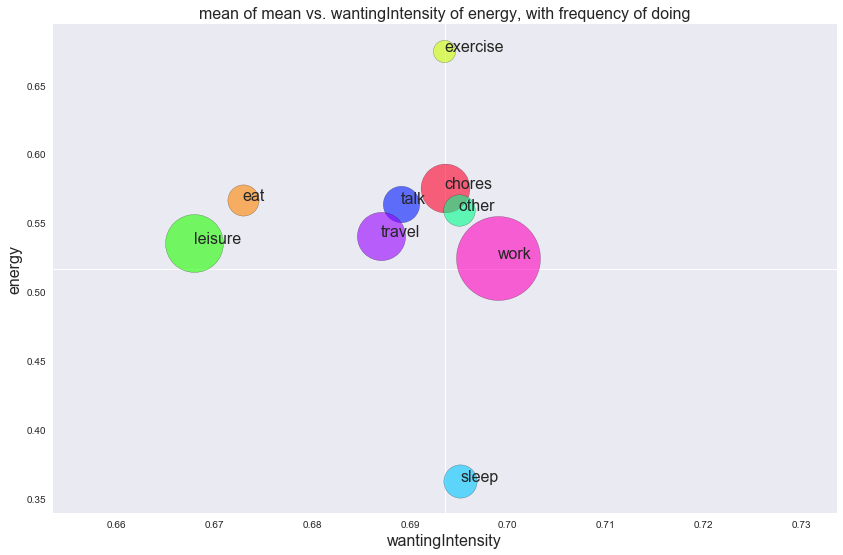

In [215]:
create_frequency_scatter_plot()

**General Function for cont. variable vs. want intensity, w/ want to feel freq **
<br> we need to perform a reverse get_dummies since want to feel is currently in dummy format and we want it to be a column of category values (one value for each 'want to feel').

In [212]:
# Don't use rows that have 0 wanting, aka drop rows with null values in 'wantingIntensity'
dfc = df[pd.notnull(df['wantingIntensity'])]

temp = dfc.copy()

temp.set_index(keys='row_id', drop=True, inplace=True)

temp = temp[wanted_to_feel_cols].stack().reset_index()

temp.rename(columns={0:'count', 'level_1':'category'}, inplace=True)

y = temp['row_id'].map(dfc[['row_id','wantingIntensity']].set_index('row_id', drop=True).squeeze())
y.name = 'wantingIntensity'
x = temp['row_id'].map(dfc[['row_id','energy']].set_index('row_id', drop=True).squeeze())
x.name = 'energy'

temp = pd.concat(objs=[temp,x,y], axis=1)

count = temp[temp['count']!=0].loc[:, ['category','count']].groupby(by='category').count()

count['count'] = count['count'] / count['count'].sum()

x = temp[temp['count']!=0].loc[:, ['category','energy']].groupby(by='category').mean()
y = temp[temp['count']!=0].loc[:, ['category','wantingIntensity']].groupby(by='category').mean()

df2 = pd.concat(objs=[x,y,count], axis=1)

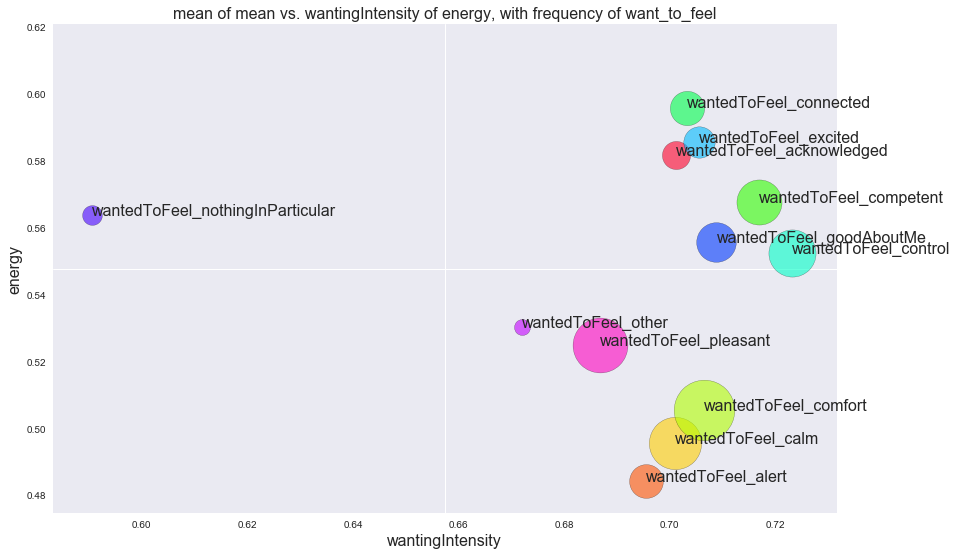

In [219]:
create_frequency_scatter_plot(average_type='mean', \
                              xaxis_var='energy', \
                              yaxis_var='wantingIntensity', \
                              circle_var='want_to_feel')

# Individual Participant Analyses 

### Histograms

In [35]:
print 'Number of participants: ',len(df['user_id'].unique())

individuals = df['user_id'].unique()

Number of participants:  95


**Make Invidual histograms for each continuous variable.**
<br>
I think the reason that this will be helpful, is at least for the reason that we want to manipulate our data so that the aggregate distributions are normal. In order to do this we would like to see how people are responding to the questions so that we can normalize the response distributions. 

https://stackoverflow.com/questions/17230797/how-to-set-the-matplotlib-figure-default-size-in-ipython-notebook

Histograms for wantingIntensity
Using 10 bins
Histograms for feelingBadToGood
Using 10 bins
Histograms for energy
Using 10 bins
Histograms for thinkingOverAndOver
Using 10 bins
Histograms for comparingToOthers
Using 10 bins
Histograms for stressed
Using 10 bins
Histograms for lonely
Using 10 bins


/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Histograms for selfWorth
Using 10 bins
Histograms for appreciating
Using 10 bins


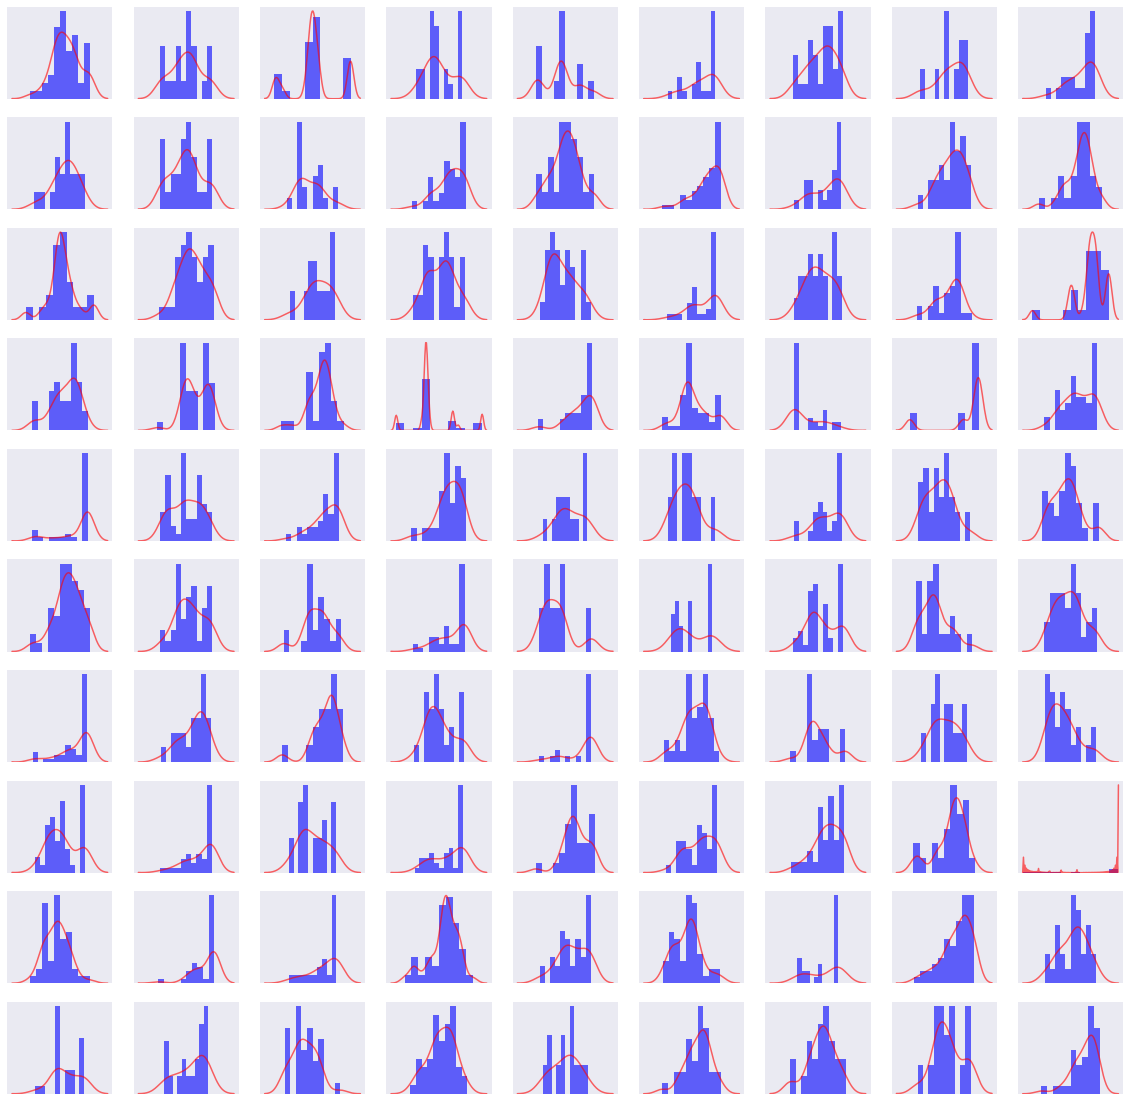

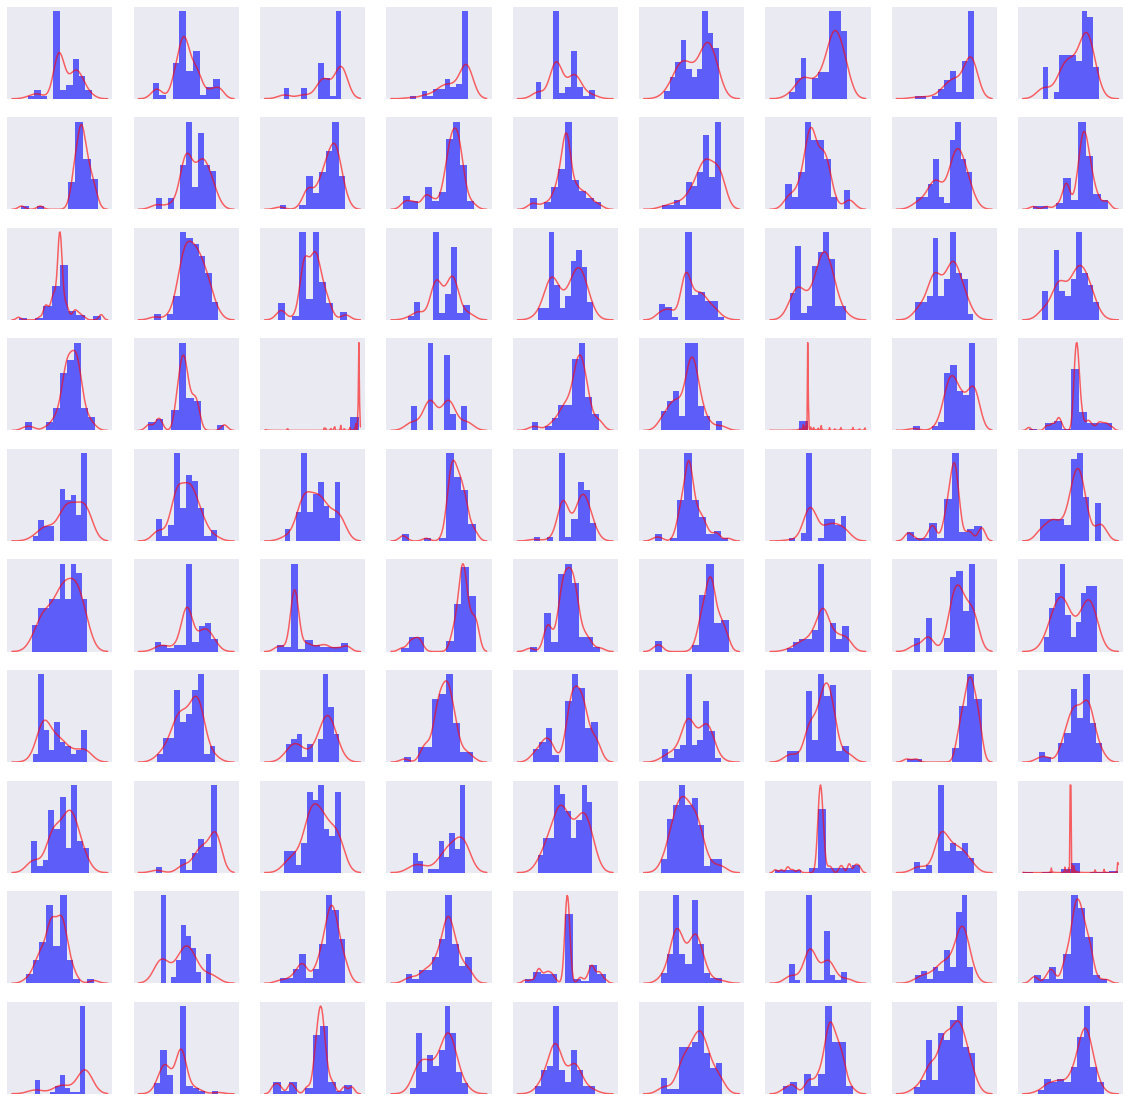

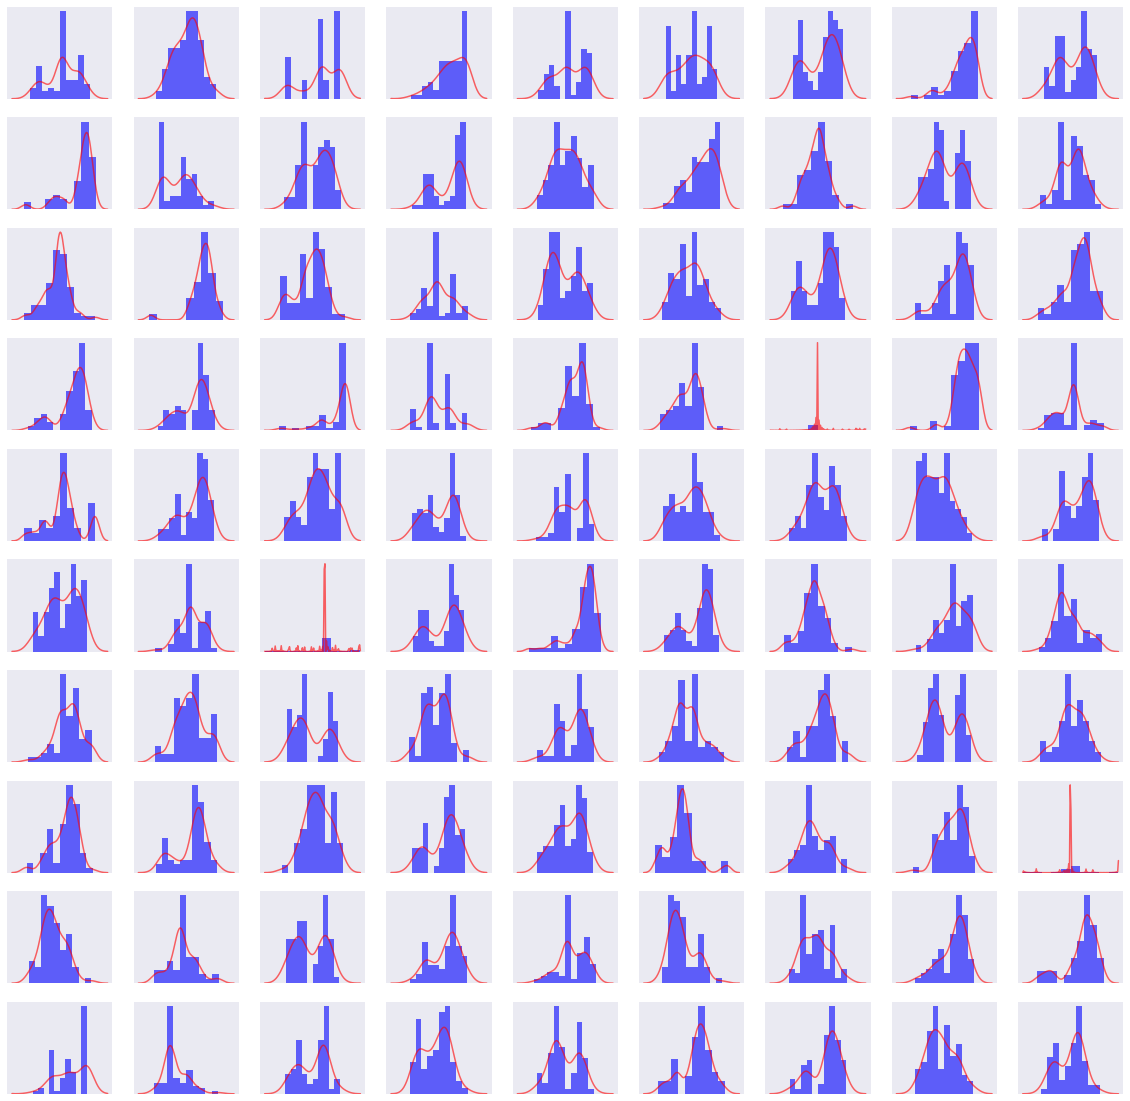

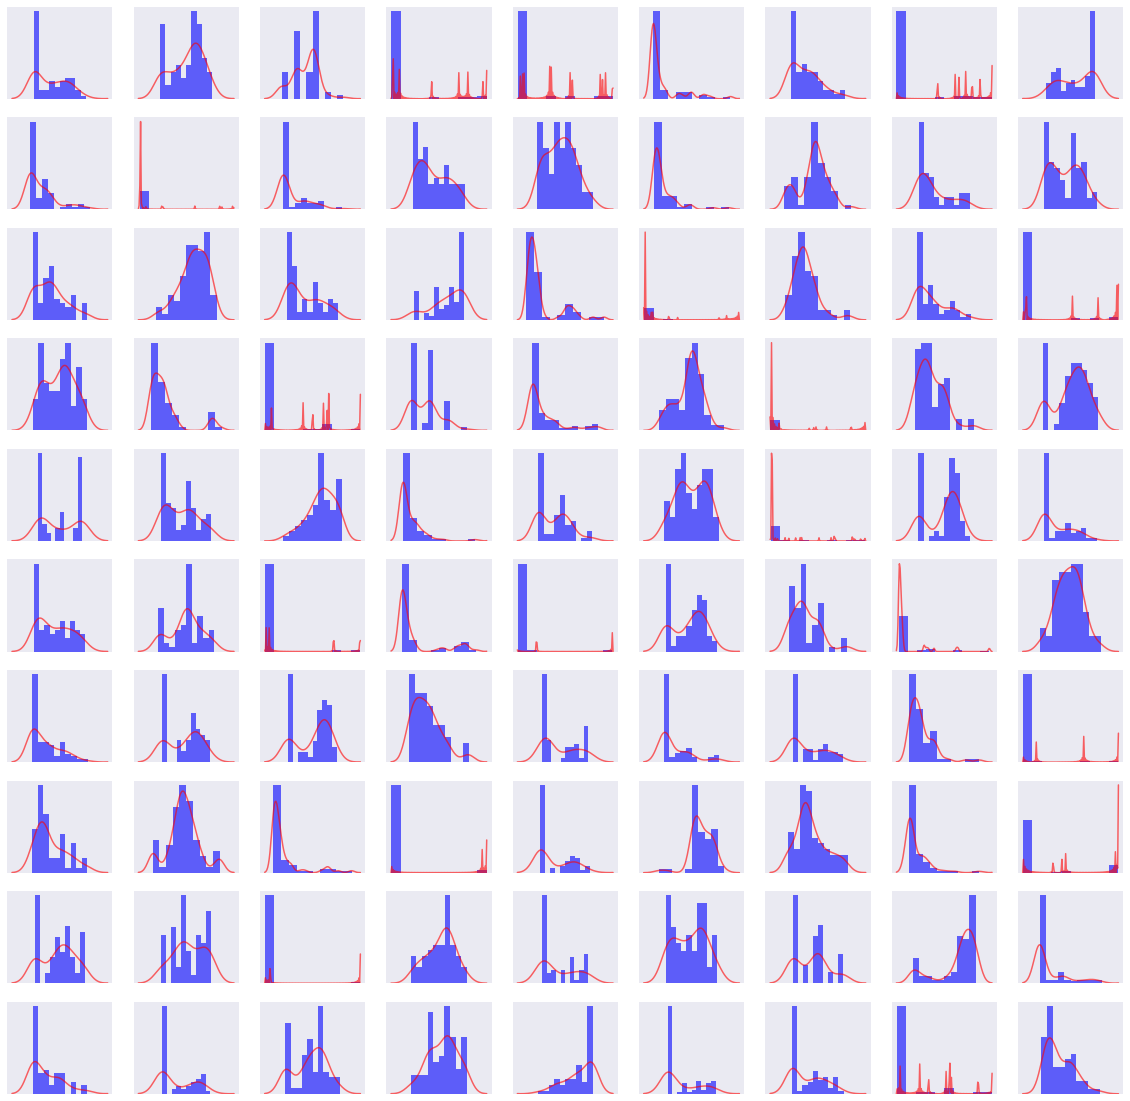

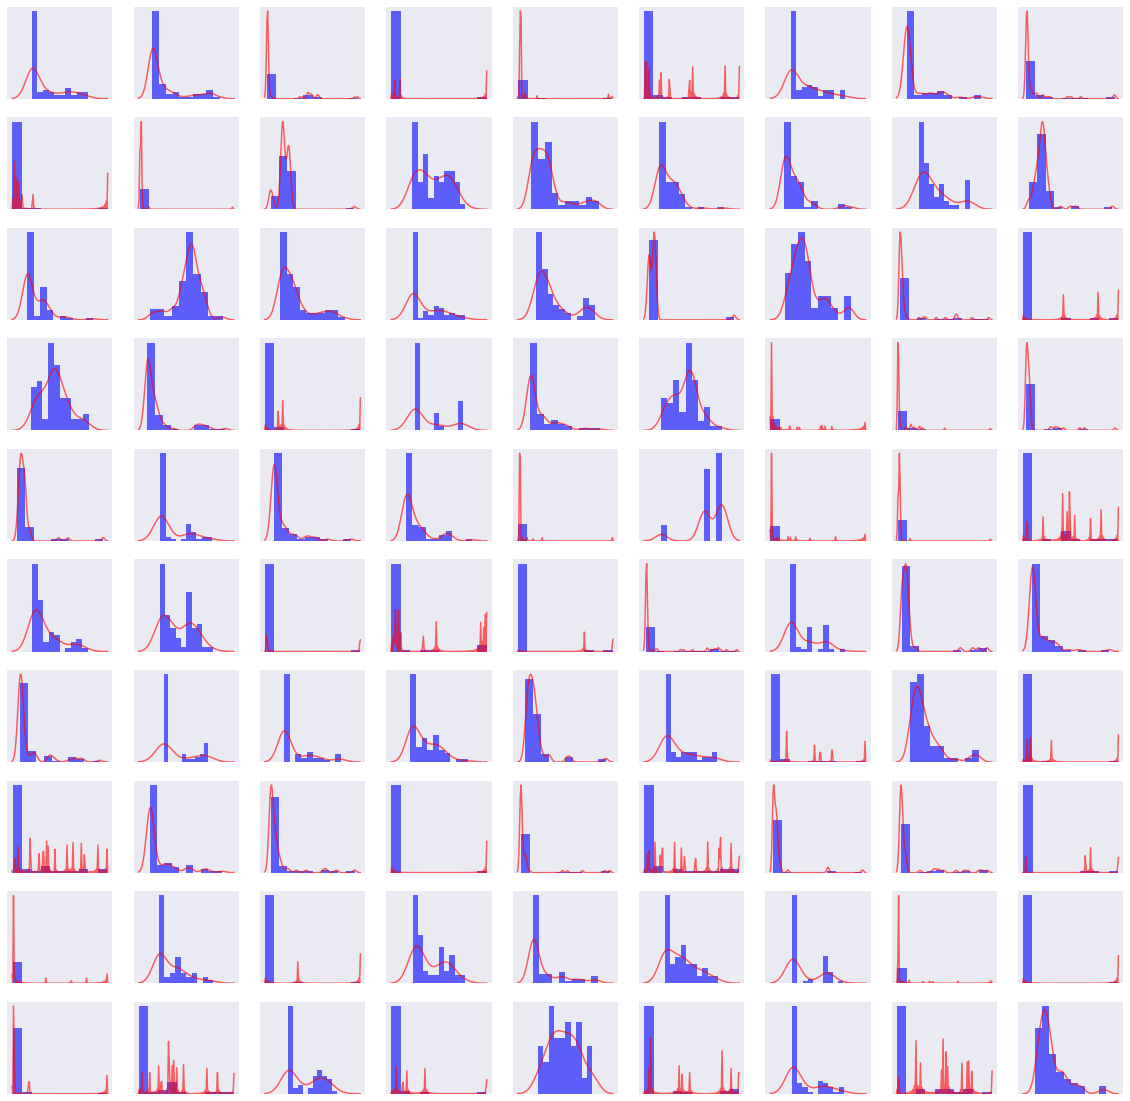

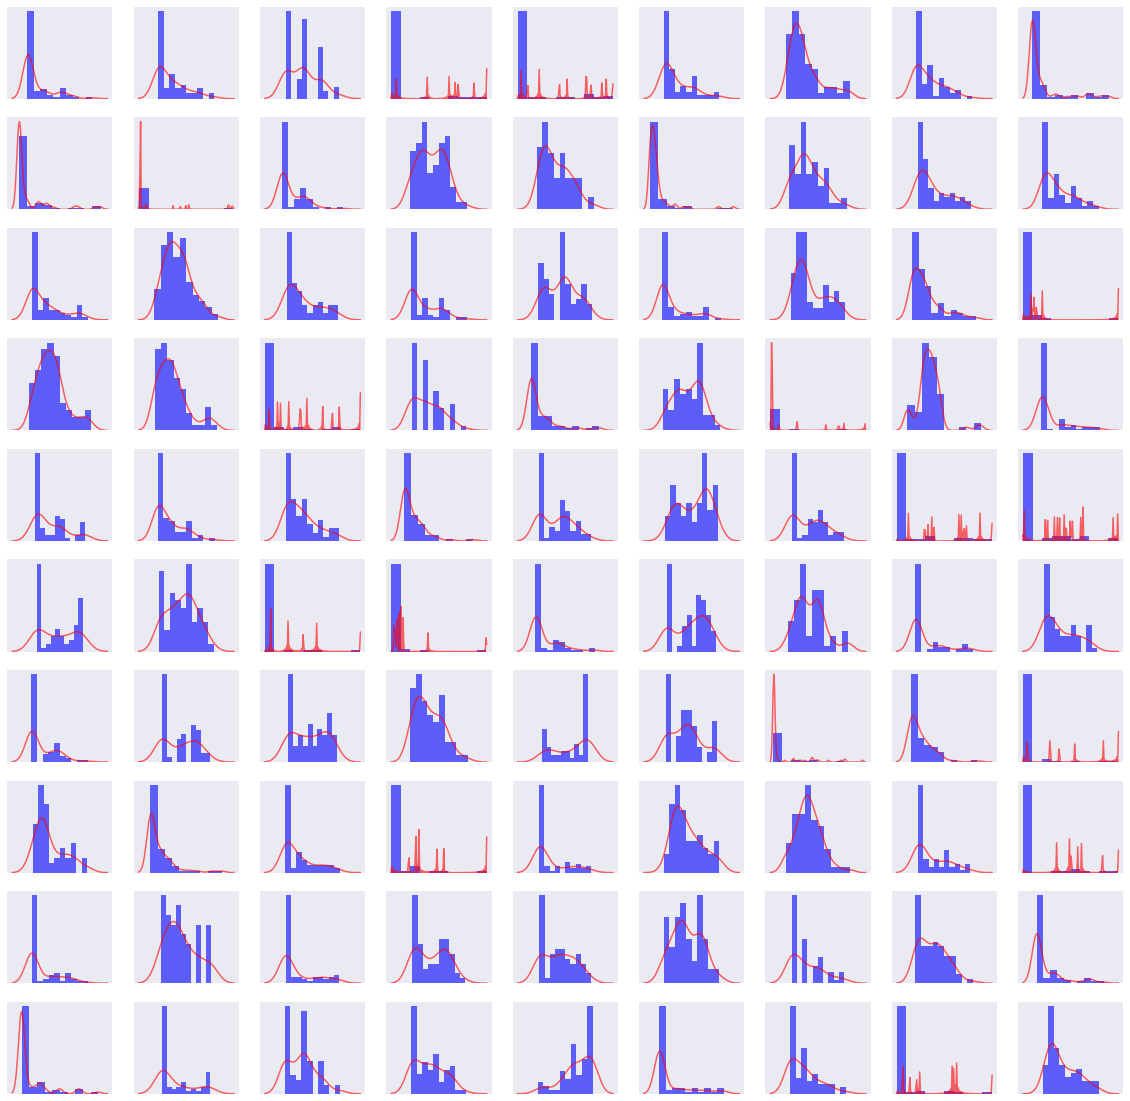

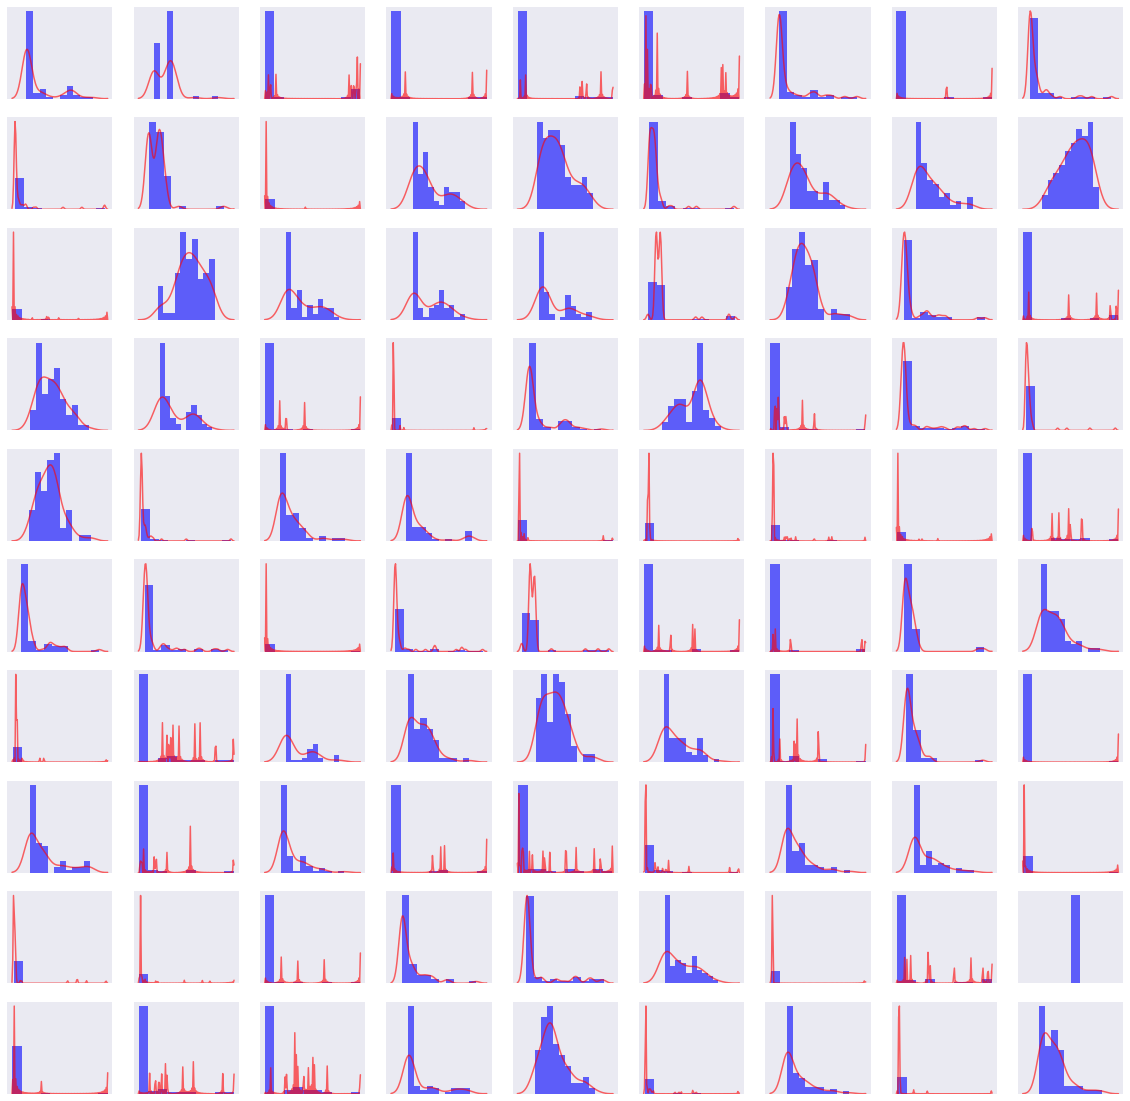

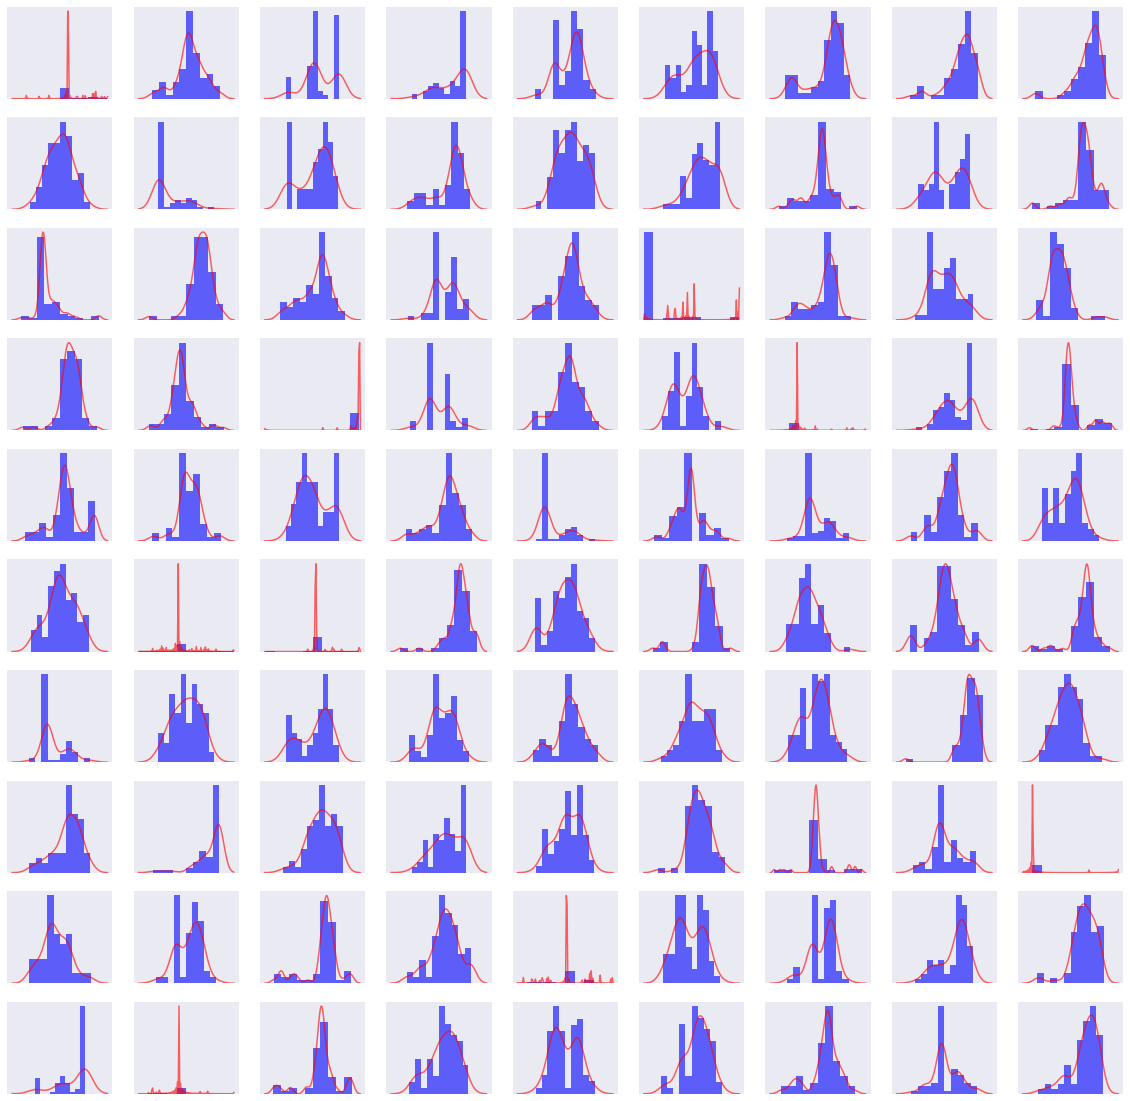

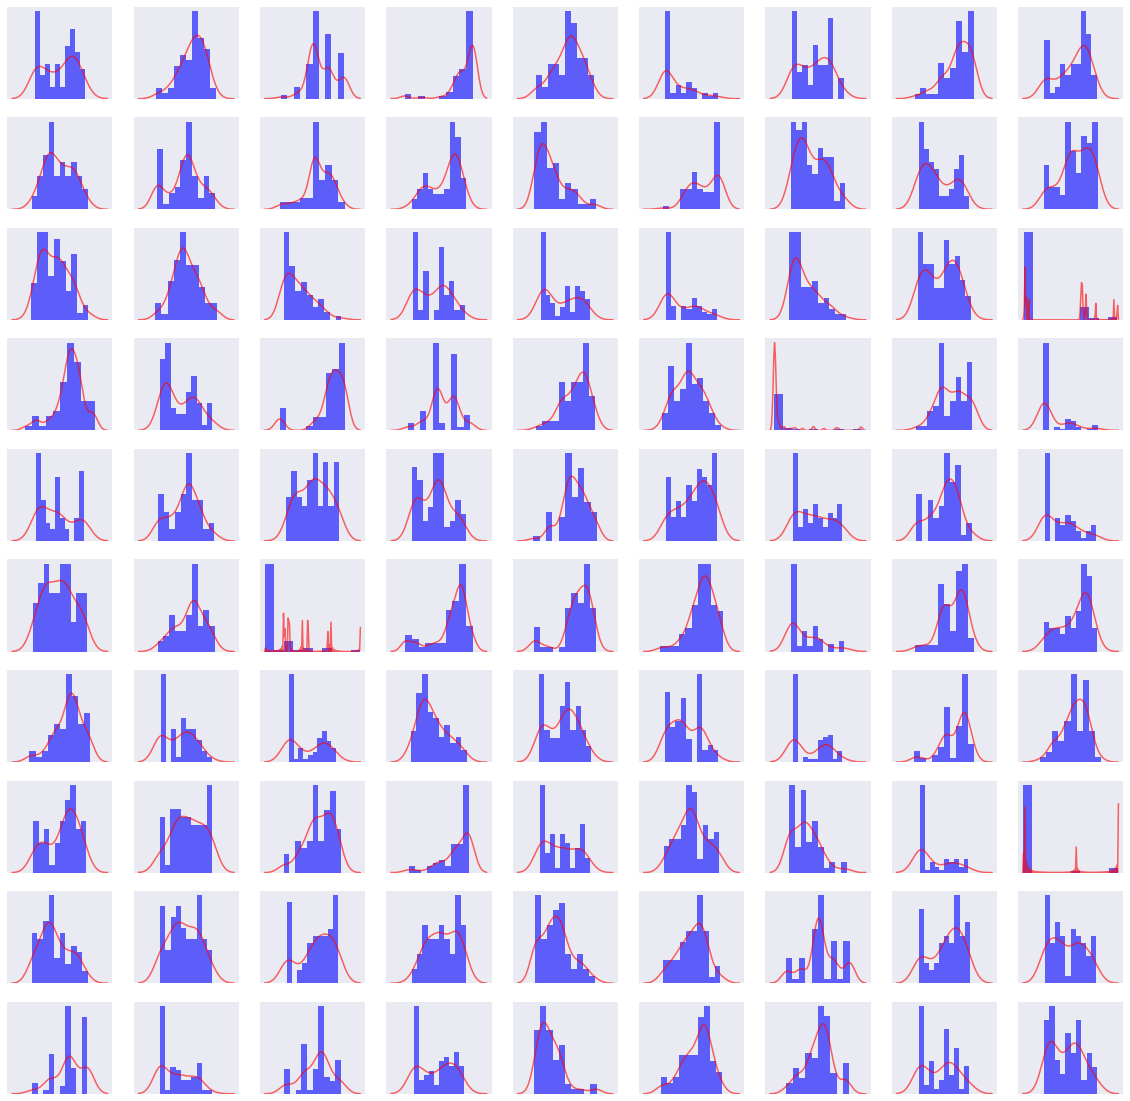

In [215]:
b = 10

for j in range(len(continuous_cols)):
    
    variable = continuous_cols[j]
    
    fig, ax = plt.subplots(nrows=10, ncols=9, figsize=(20,20))
    ax = ax.ravel()
    
    print 'Histograms for %s' % variable
    print 'Using %s bins' % b
    
    for i in range(ax.shape[0]):
        p = df.loc[df['user_id']==individuals[i], variable]
        p = p[~p.isnull()]
        g = sns.distplot(a=p, \
                     bins=b, \
                     norm_hist=True, \
                     kde=True, \
                     color='blue', \
                     hist_kws={'alpha':0.6}, \
                     kde_kws={'color':'red', 'linewidth':1.5, 'alpha':0.6},\
                     ax=ax[i])
        ax[i].set_ylabel('')    
        ax[i].set_xlabel('')
        g.set(yticks=[])
        g.set(xticks=[])

    plt.savefig('./images-esm/individual-histograms-{}.png'.format(variable))

Using seaborn
https://github.com/mwaskom/seaborn/issues/108

In [216]:
# grid = sns.FacetGrid(df, row='user_id', col=continuous_cols[0], xlim=(4, -2),
#                      sharey=False, margin_titles=False)

# grid.map(sns.distplot, 'first_hurtful_prime',bins=np.arange(-2, 4, 0.3), 
#                       hist_kws=dict(alpha=0.1))
# grid.map(sns.plt.axvline, x=0, c='grey', lw=1)
# grid.set(yticks=[])